In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

In [2]:
# Fred Data
from fredapi import Fred
fred_key = "c03aebf8c0cedfaa61c1a52996876920"
# Initiates a session with the FRED datacenter to recieve datasets
fred = Fred(api_key=fred_key)

In [3]:
from lightgbm import LGBMClassifier

In [4]:
from pytrends.request import TrendReq

## Getting different VIX data directly from Cboe

In [5]:
# First read information about VIX and similar index for emergin markets
start = "2007-05-10" # Thursday May 10, 2007

VIX = pd.read_csv('https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv')
Cboe = VIX.loc[:,['DATE','CLOSE']]
Cboe.columns = ['DATE','VIX']

# Take the dates of interest
Cboe['DATE'] = pd.to_datetime(Cboe['DATE'])
Cboe.set_index('DATE', inplace=True)
Cboe.index.names = ['Date']
Cboe = Cboe.loc[start:, ]
# Fill the missing values with the past ones
Cboe.fillna(method='ffill', inplace=True)

Cboe

VIX
Date             
2007-05-10  13.60
2007-05-11  12.95
2007-05-14  13.96
2007-05-15  14.01
2007-05-16  13.50
...           ...
2023-08-28  15.08
2023-08-29  14.45
2023-08-30  13.88
2023-08-31  13.57
2023-09-01  13.09

[4118 rows x 1 columns]

## Getting data from Yahoo Finance about some common indices

In [6]:
# Yahoo Finance Data
tickers = ['^GSPC','EEM','GC=F','CL=F','DX-Y.NYB','^OVX'] # VIX, EEM, Gold, Oil, USD Index and OVX-Oil

Yahoo_data = yf.download(tickers=tickers, start=start)['Close']

# Fill missing values with previous ones
Yahoo_data.fillna(method='ffill', inplace=True)

[*********************100%***********************]  6 of 6 completed


In [7]:
Yahoo_data.columns

Index(['CL=F', 'DX-Y.NYB', 'EEM', 'GC=F', '^GSPC', '^OVX'], dtype='object')

In [8]:
Yahoo_data.columns = ['Oil', 'USD Index', 'EEM', 'Gold', 'SP500', 'OVX']

<AxesSubplot:xlabel='Date'>

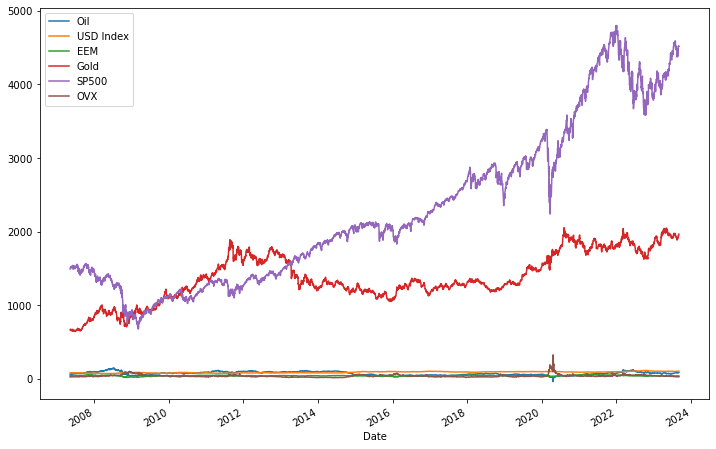

In [9]:
Yahoo_data.plot(figsize=(12,8))

## Computing wekly returns

### Weekly returns (on first business day of week)

In [10]:
end = '2023-08-29'
Fridays = pd.date_range(start=start, end=end, freq='W')[1:] - timedelta(days=2)
Mondays = Fridays + timedelta(days = 3)

In [11]:
# Taking the first and last business day of each week in the respective Series data

# for the data of Cboe
index_row = 0
Yahoo_monday = []
for date in Fridays:
    while Yahoo_data.index[index_row] <= date:
        index_row += 1
    Yahoo_monday.append(index_row)
    
#Yahoo_friday = [i - 1 for i in Yahoo_monday]

In [12]:
# Weekly returns considered each Monday
SP_return_monday = np.log(Yahoo_data['SP500'].iloc[Yahoo_monday]) - np.log(Yahoo_data['SP500'].iloc[Yahoo_monday]).shift(1)
SP_return_monday.index = Mondays
SP_return_monday

2007-05-21         NaN
2007-05-28   -0.004594
2007-06-04    0.013784
2007-06-11   -0.019723
2007-06-18    0.014427
                ...   
2023-07-31    0.007507
2023-08-07   -0.015487
2023-08-14   -0.006376
2023-08-21   -0.020238
2023-08-28    0.007594
Name: SP500, Length: 850, dtype: float64

#  Getting FRED Data

In [13]:
# Getting the Daily and wekly data from Fred
FRED_daily_series = [
    'BAMLC0A4CBBB', # ICE BofA BBB US Corporate Index Option-Adjusted Spread - Daily
    'BAMLC0A4CBBBEY', # ICE BofA BBB US Corporate Index Effective Yield - Daily
    'BAMLC0A1CAAA', # ICE BofA AAA US Corporate Index Option-Adjusted Spread - Daily
    'BAMLC0A1CAAAEY', # ICE BofA AAA US Corporate Index Effective Yield - Daily
    'BAMLH0A0HYM2', # ICE BofA US High Yield Index Option-Adjusted Spread - Daily
    'T10Y3M', # 10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity - Daily
    'T10YIE', # 10-Year Breakeven Inflation Rate - Daily
    'T5YIE', # 5-Year Breakeven Inflation Rate - Daily
    'TEDRATE', # TED Spread (DISCONTINUED) - Daily
    'EFFR', # Effective Federal Funds Rate - Daily
    'DFII5', # Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity', # Quoted on an Investment Basis', #
            # Inflation-Indexed - Daily
    # From the last two we are going to take the first difference
    'USEPUINDXD', # Economic Policy Uncertainty Index for United States - Daily
    'WLEMUINDXD', # Equity Market-related Economic Uncertainty Index - Daily
]

FRED_weekly_series = [
    'STLFSI4', # St. Louis Fed Financial Stress Index, Weekly
    'WM2NS', # M2, Weekly
    # From the last two we are going to take the logarithmic returns
    'ICNSA', # Initial Claims, Weekly, Not Seasonally Adjusted 
    'ICSA', # Initial Claims, Weekly, Seasonally Adjusted
]

# Names of the columns
Daily_column_names = [
    'BBB Corp OAS',
    'BBB Corp Yield',
    'AAA Copr OAS',
    'AAA Corp Yield',
    'Corp Yield',
    'Yield Spread',
    '10Y Breakeven Inflation',
    '5Y Breakeven Inflation',
    'TED Spread',
    'Fed Rate',
    '5Y Yield Inflation Indexed',
    'EPU Index',
    'EPU Equity Index'
]

Weekly_column_names = [
    'Financial Stress Index',
    'M2 Money Supply',
    'Initial Claims NSA',
    'Initial Claims SA'
]

In [14]:
# Getting the Daily and Wekly data from Fred
Fred_Daily_list = []
# Adding FRED datasets
for series_id in FRED_daily_series:
    df = pd.DataFrame(fred.get_series(series_id), columns=[series_id]).loc[start:]
    Fred_Daily_list.append(df)
    
Fred_Weekly_list = []
# Adding FRED datasets
for series_id in FRED_weekly_series:
    df = pd.DataFrame(fred.get_series(series_id), columns=[series_id]).loc[start:]
    Fred_Weekly_list.append(df)
    
# Combine information into DataFrames
Fred_Daily = pd.concat(Fred_Daily_list, axis=1, join='outer')
Fred_Weekly = pd.concat(Fred_Weekly_list, axis=1, join='outer')

# Giving names to the columns for easier identification
Fred_Daily.columns = Daily_column_names
Fred_Weekly.columns = Weekly_column_names

In [15]:
# Combine information from Fred with information form Cboe and Yahoo finance
Daily_data = pd.concat([Fred_Daily, Cboe['VIX'], Yahoo_data.loc[:,['OVX','USD Index', 'Oil', 'Gold']]],
                       axis=1, join='outer')

# Fill missing values with previous ones
Daily_data.fillna(method='ffill', inplace=True)

In [16]:
# We are going to consider the weekly averages at the end of each week
Week_average = Daily_data.rolling(5).mean().loc[Fridays, :] 

# Let's taket the 1 week difference from 'EPU Index, EPU Equity Index'
print('1 week differences: ' +  str(Week_average.columns[-7:-4]))
Week_average.iloc[:, -7:-4] = Week_average.iloc[:, -7:-4].diff(1)

# Now we take the logarithmic return of OVX, USD Index, Oil and Gold
print('Weekly logarithmic returns: ' + str(Week_average.columns[-4:]))
Week_average.iloc[:, -4:] = np.log(Week_average.iloc[:, -4:]) - np.log(Week_average.iloc[:, -4:].shift(1))

1 week differences: Index(['EPU Index', 'EPU Equity Index', 'VIX'], dtype='object')
Weekly logarithmic returns: Index(['OVX', 'USD Index', 'Oil', 'Gold'], dtype='object')


In [17]:
Week_average

BBB Corp OAS  BBB Corp Yield  AAA Copr OAS  AAA Corp Yield  \
2007-05-18         1.172           5.948         0.600           5.360   
2007-05-25         1.162           6.040         0.600           5.456   
2007-06-01         1.176           6.110         0.612           5.530   
2007-06-08         1.202           6.246         0.620           5.648   
2007-06-15         1.216           6.408         0.624           5.782   
...                  ...             ...           ...             ...   
2023-07-28         1.506           5.790         0.500           4.746   
2023-08-04         1.492           5.868         0.490           4.854   
2023-08-11         1.514           5.892         0.500           4.870   
2023-08-18         1.534           6.068         0.504           5.024   
2023-08-25         1.532           6.098         0.488           5.032   

            Corp Yield  Yield Spread  10Y Breakeven Inflation  \
2007-05-18       2.564        -0.080                    2.348   
2007-05-25       2.460        -0.062                    2.364   
2007-06-01       2.436         0.064                    2.362   
2007-06-08       2.464         0.220                    2.398   
2007-06-15       2.504         0.534                    2.438   
...                ...           ...                      ...   
2023-07-28       3.834        -1.592                    2.376   
2023-08-04       3.912        -1.470                    2.370   
2023-08-11       3.914        -1.480                    2.360   
2023-08-18       3.884        -1.310                    2.330   
2023-08-25       3.926        -1.310                    2.338   

            5Y Breakeven Inflation  TED Spread  Fed Rate  \
2007-05-18                   2.366       0.674     5.258   
2007-05-25                   2.354       0.592     5.250   
2007-06-01                   2.338       0.664     5.268   
2007-06-08                   2.368       0.688     5.238   
2007-06-15                   2.400       0.826     5.266   
...                            ...         ...       ...   
2023-07-28                   2.266       0.090     5.180   
2023-08-04                   2.256       0.090     5.330   
2023-08-11                   2.262       0.090     5.330   
2023-08-18                   2.244       0.090     5.330   
2023-08-25                   2.254       0.090     5.330   

            5Y Yield Inflation Indexed  EPU Index  EPU Equity Index    VIX  \
2007-05-18                       2.290        NaN               NaN    NaN   
2007-05-25                       2.416      7.666           -32.142 -0.144   
2007-06-01                       2.508    -30.170           -18.896 -0.298   
2007-06-08                       2.616      1.696             8.304  1.632   
2007-06-15                       2.728     21.076            -4.572  0.000   
...                                ...        ...               ...    ...   
2023-07-28                       1.892    -19.322           -40.422  0.114   
2023-08-04                       1.966    -12.852            83.320  1.594   
2023-08-11                       1.918    -15.304          -117.024  0.348   
2023-08-18                       2.144     31.172            34.566  0.968   
2023-08-25                       2.174     -3.032            34.956 -0.058   

                 OVX  USD Index       Oil      Gold  
2007-05-18       NaN        NaN       NaN       NaN  
2007-05-25 -0.017378   0.003162  0.026104 -0.008138  
2007-06-01  0.064230  -0.000267 -0.016870  0.001669  
2007-06-08 -0.040345  -0.002091  0.026262  0.005353  
2007-06-15 -0.015119   0.009183  0.011348 -0.017681  
...              ...        ...       ...       ...  
2023-07-28 -0.023967   0.009852  0.051238 -0.004339  
2023-08-04 -0.048532   0.008505  0.022887 -0.007880  
2023-08-11 -0.024422   0.002188  0.020042 -0.012412  
2023-08-18  0.024070   0.008182 -0.026228 -0.012673  
2023-08-25  0.010499   0.003227 -0.014141  0.006110  

[850 rows x 18 columns]

In [18]:
# For the weekly data Financial Stress Index is provided on Friday, M2 Money Supply on Mondays,
# Initial Claims NSA and Intial Claims SA on Saturdays,
# so we are going to backfill data and take the coresponding data that we can have before the closing of Mondays
Fred_Weekly.fillna(method='ffill', inplace=True)
Fred_Weekly = Fred_Weekly.loc[Fridays, :]
Fred_Weekly.iloc[:, -2:] = np.log(Fred_Weekly.iloc[:, -2:]) - np.log(Fred_Weekly.iloc[:, -2:].shift(1))

In [19]:
Fred_Weekly

Financial Stress Index  M2 Money Supply  Initial Claims NSA  \
2007-05-18                 -0.9753           7251.8                 NaN   
2007-05-25                 -1.0206           7240.9            0.045115   
2007-06-01                 -0.9628           7218.2            0.010853   
2007-06-08                 -0.8547           7286.8           -0.036769   
2007-06-15                 -0.7900           7295.4            0.137489   
...                            ...              ...                 ...   
2023-07-28                 -0.7902          20709.4           -0.189992   
2023-08-04                 -0.7666          20756.9           -0.037933   
2023-08-11                 -0.6756          20756.9            0.103292   
2023-08-18                 -0.6683          20756.9           -0.063926   
2023-08-25                 -0.7220          20756.9           -0.069557   

            Initial Claims SA  
2007-05-18                NaN  
2007-05-25           0.042840  
2007-06-01           0.000000  
2007-06-08           0.009631  
2007-06-15           0.000000  
...                       ...  
2023-07-28          -0.031183  
2023-08-04           0.026787  
2023-08-11           0.096511  
2023-08-18          -0.040822  
2023-08-25          -0.033902  

[850 rows x 4 columns]

In [20]:
Macroeconomics = pd.concat([Week_average, Fred_Weekly], axis=1, join='outer').iloc[1:, :]

In [21]:
Macroeconomics

BBB Corp OAS  BBB Corp Yield  AAA Copr OAS  AAA Corp Yield  \
2007-05-25         1.162           6.040         0.600           5.456   
2007-06-01         1.176           6.110         0.612           5.530   
2007-06-08         1.202           6.246         0.620           5.648   
2007-06-15         1.216           6.408         0.624           5.782   
2007-06-22         1.216           6.342         0.628           5.720   
...                  ...             ...           ...             ...   
2023-07-28         1.506           5.790         0.500           4.746   
2023-08-04         1.492           5.868         0.490           4.854   
2023-08-11         1.514           5.892         0.500           4.870   
2023-08-18         1.534           6.068         0.504           5.024   
2023-08-25         1.532           6.098         0.488           5.032   

            Corp Yield  Yield Spread  10Y Breakeven Inflation  \
2007-05-25       2.460        -0.062                    2.364   
2007-06-01       2.436         0.064                    2.362   
2007-06-08       2.464         0.220                    2.398   
2007-06-15       2.504         0.534                    2.438   
2007-06-22       2.612         0.446                    2.422   
...                ...           ...                      ...   
2023-07-28       3.834        -1.592                    2.376   
2023-08-04       3.912        -1.470                    2.370   
2023-08-11       3.914        -1.480                    2.360   
2023-08-18       3.884        -1.310                    2.330   
2023-08-25       3.926        -1.310                    2.338   

            5Y Breakeven Inflation  TED Spread  Fed Rate  ...  \
2007-05-25                   2.354       0.592     5.250  ...   
2007-06-01                   2.338       0.664     5.268  ...   
2007-06-08                   2.368       0.688     5.238  ...   
2007-06-15                   2.400       0.826     5.266  ...   
2007-06-22                   2.380       0.800     5.242  ...   
...                            ...         ...       ...  ...   
2023-07-28                   2.266       0.090     5.180  ...   
2023-08-04                   2.256       0.090     5.330  ...   
2023-08-11                   2.262       0.090     5.330  ...   
2023-08-18                   2.244       0.090     5.330  ...   
2023-08-25                   2.254       0.090     5.330  ...   

            EPU Equity Index    VIX       OVX  USD Index       Oil      Gold  \
2007-05-25           -32.142 -0.144 -0.017378   0.003162  0.026104 -0.008138   
2007-06-01           -18.896 -0.298  0.064230  -0.000267 -0.016870  0.001669   
2007-06-08             8.304  1.632 -0.040345  -0.002091  0.026262  0.005353   
2007-06-15            -4.572  0.000 -0.015119   0.009183  0.011348 -0.017681   
2007-06-22             0.342 -0.558  0.048852  -0.004302  0.032303  0.006000   
...                      ...    ...       ...        ...       ...       ...   
2023-07-28           -40.422  0.114 -0.023967   0.009852  0.051238 -0.004339   
2023-08-04            83.320  1.594 -0.048532   0.008505  0.022887 -0.007880   
2023-08-11          -117.024  0.348 -0.024422   0.002188  0.020042 -0.012412   
2023-08-18            34.566  0.968  0.024070   0.008182 -0.026228 -0.012673   
2023-08-25            34.956 -0.058  0.010499   0.003227 -0.014141  0.006110   

            Financial Stress Index  M2 Money Supply  Initial Claims NSA  \
2007-05-25                 -1.0206           7240.9            0.045115   
2007-06-01                 -0.9628           7218.2            0.010853   
2007-06-08                 -0.8547           7286.8           -0.036769   
2007-06-15                 -0.7900           7295.4            0.137489   
2007-06-22                 -0.6962           7305.5           -0.038490   
...                            ...              ...                 ...   
2023-07-28                 -0.7902          20709.4           -0.189992   


# Light Gradient Boosting Machine

In [22]:
VIX_return_increment = (Week_average['VIX'] > 0) + 0

In [23]:
# Separating the independent and target variable on both data set
x_train = Macroeconomics.loc[:'2021-12-31'].iloc[:-50]
y_train = VIX_return_increment.loc[:'2022-01-07'].iloc[2:-50]
x_test = Macroeconomics.loc[:'2021-12-31'].iloc[-50:]
y_test = VIX_return_increment.loc[:'2022-01-07'].iloc[-50:]
 
# Creating an object for model and fitting it on training data set
LGBMC_model = LGBMClassifier(objective='binary', importance_type='gain')
LGBMC_model.fit(x_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 331, number of negative: 382
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5207
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464236 -> initscore=-0.143302
[LightGBM] [Info] Start training from score -0.143302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

LGBMClassifier(importance_type='gain', objective='binary')

In [24]:
# Predicting the Target variable
LGBMC_prediction = LGBMC_model.predict(x_test)
print(LGBMC_prediction)
accuracy = LGBMC_model.score(x_test, y_test)
print(accuracy)

[0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 1 1 0 0
 0 0 1 1 1 0 0 0 1 0 1 1 1]
0.54


In [25]:
# Creating an object for model and fitting it on training data set
LGBMC_model = LGBMClassifier(boosting_type='gbdt', num_leaves=2, max_depth=2, learning_rate=40, n_estimators=1020,
                             subsample_for_bin=485, objective='binary', min_split_gain=1e-19, min_child_weight=1e-19, 
                             min_child_samples=306, subsample=0.01, colsample_bytree=0.37, reg_alpha=1e-19, reg_lambda=1e5,
                             importance_type='gain')

LGBMC_model.fit(x_train, y_train)
 
# Predicting the Target variable
LGBMC_prediction = LGBMC_model.predict(x_test)
print(LGBMC_prediction)
accuracy = LGBMC_model.score(x_test, y_test)
print(accuracy)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 331, number of negative: 382
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3472
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464236 -> initscore=-0.143302
[LightGBM] [Info] Start training from score -0.143302
[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 1 1 0 0 0 0 0 0 1 0 1 1]
0.56


Text(0.5, 1.0, 'SP500')

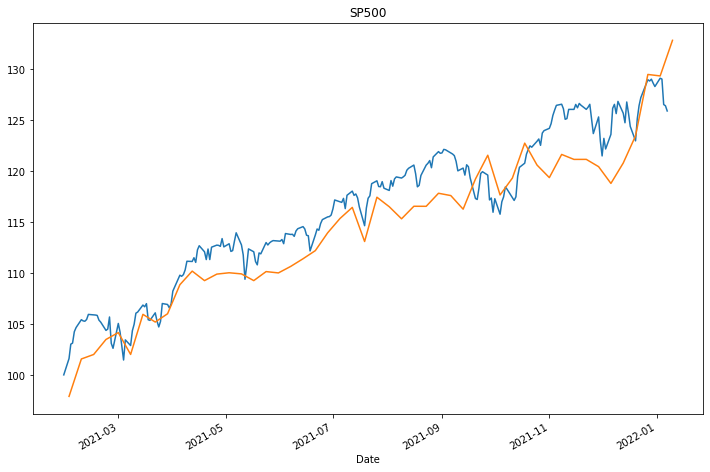

In [26]:
SP_return_test =  SP_return_monday.loc[y_test.index[0] : y_test.index[-1] + timedelta(days=4)]
Returns_estrategy = SP_return_test * (-2 * LGBMC_prediction + 1)

fig, ax = plt.subplots(1)
(Yahoo_data.loc[y_test.index[0] : y_test.index[-1], 'SP500'] / Yahoo_data.loc[y_test.index[0], 'SP500'] * 100).plot(ax=ax, figsize = (12,8))
(np.exp(np.cumsum(Returns_estrategy)) * 100).plot(ax = ax) 

plt.title('SP500')

# Google trends

## Debt

In [27]:
# specify we want to use language as US english and the standard US-time zone 
pytrends = TrendReq(hl='en-US', tz=360) 

# By now we are going to focus on the word debt
kw_list = ['debt'] 
#pytrends only allow us to download data in a 5Y window, so we are going to merge different queries
pytrends.build_payload(kw_list, cat=0, timeframe='2007-04-28 2010-01-07', geo='', gprop='')
debt_1 = pytrends.interest_over_time()['debt']
pytrends.build_payload(kw_list, cat=0, timeframe='2010-01-01 2015-01-07', geo='', gprop='')
debt_2 = pytrends.interest_over_time()['debt']
pytrends.build_payload(kw_list, cat=0, timeframe='2015-01-01 2020-01-07', geo='', gprop='')
debt_3 = pytrends.interest_over_time()['debt']
pytrends.build_payload(kw_list, cat=0, timeframe='2020-01-01 2023-09-01', geo='', gprop='')
debt_4 = pytrends.interest_over_time()['debt']

# Normalie overall periods
debt_4 = debt_4.astype(float)
debt_3 = debt_3 / debt_3[-1]  * debt_4[0]
debt_2 = debt_2 / debt_2[-1]  * debt_3[0]
debt_1 = debt_1 / debt_1[-1]  * debt_2[0]

Debt_trends = pd.DataFrame(pd.concat([debt_1[:-1], debt_2[:-1], debt_3[:-1], debt_4], axis=0, join='outer'))

In [28]:
Debt_trends['2W average'] = Debt_trends['debt'].rolling(2).mean()
Debt_trends['3W average'] = Debt_trends['debt'].rolling(3).mean()
Debt_trends['4W average'] = Debt_trends['debt'].rolling(4).mean()
Debt_trends['Diff 1'] = Debt_trends['debt'].diff(1)
Debt_trends['Diff 2'] = Debt_trends['debt'] - Debt_trends['2W average'].shift(1)
Debt_trends['Diff 3'] = Debt_trends['debt'] - Debt_trends['3W average'].shift(1)
Debt_trends['Diff 4'] = Debt_trends['debt'] - Debt_trends['4W average'].shift(1)
Debt_trends.drop(Debt_trends.index[:3], inplace=True)

Debt_trends.index = Mondays

In [29]:
Signal_debt_diff1 = 2 * (Debt_trends['Diff 1'] < 0) - 1
Signal_debt_diff2 = 2 * (Debt_trends['Diff 2'] < 0) - 1
Signal_debt_diff3 = 2 * (Debt_trends['Diff 3'] < 0) - 1
Signal_debt_diff4 = 2 * (Debt_trends['Diff 4'] < 0) - 1

In [30]:
Debt_trends

debt  2W average  3W average  4W average    Diff 1  \
2007-05-21  33.712775   35.897862   36.626225   38.239027 -4.370175   
2007-05-28  33.712775   33.712775   35.169500   35.897862  0.000000   
2007-06-04  37.458639   35.585707   34.961396   35.741785  3.745864   
2007-06-11  35.585707   36.522173   35.585707   35.117474 -1.872932   
2007-06-18  32.464154   34.024930   35.169500   34.805319 -3.121553   
...               ...         ...         ...         ...       ...   
2023-07-31  36.000000   34.500000   35.333333   36.000000  3.000000   
2023-08-07  36.000000   36.000000   35.000000   35.500000  0.000000   
2023-08-14  33.000000   34.500000   35.000000   34.500000 -3.000000   
2023-08-21  37.000000   35.000000   35.333333   35.500000  4.000000   
2023-08-28  39.000000   38.000000   36.333333   36.250000  2.000000   

                  Diff 2        Diff 3    Diff 4  
2007-05-21 -4.370175e+00 -6.035003e+00       NaN  
2007-05-28 -2.185087e+00 -2.913450e+00 -4.526252  
2007-06-04  3.745864e+00  2.289139e+00  1.560777  
2007-06-11  7.105427e-15  6.243107e-01 -0.156078  
2007-06-18 -4.058019e+00 -3.121553e+00 -2.653320  
...                  ...           ...       ...  
2023-07-31  1.000000e+00  7.105427e-15  0.250000  
2023-08-07  1.500000e+00  6.666667e-01  0.000000  
2023-08-14 -3.000000e+00 -2.000000e+00 -2.500000  
2023-08-21  2.500000e+00  2.000000e+00  2.500000  
2023-08-28  4.000000e+00  3.666667e+00  3.500000  

[850 rows x 8 columns]

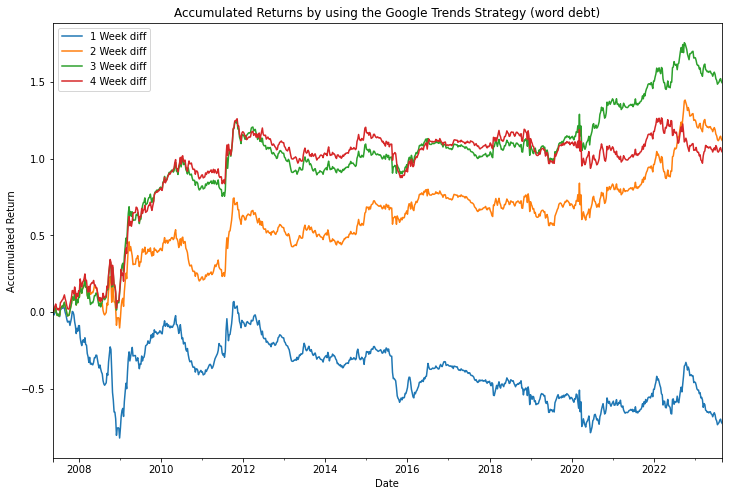

In [31]:
fig, ax = plt.subplots(1, figsize=(12,8))
(np.cumsum(SP_return_monday * Signal_debt_diff1.shift(1))).plot(ax = ax, legend=True, label='1 Week diff') 
(np.cumsum(SP_return_monday * Signal_debt_diff2.shift(1))).plot(ax = ax, legend=True, label='2 Week diff') 
(np.cumsum(SP_return_monday * Signal_debt_diff3.shift(1))).plot(ax = ax, legend=True, label='3 Week diff') 
(np.cumsum(SP_return_monday * Signal_debt_diff4.shift(1))).plot(ax = ax, legend=True, label='4 Week diff') 
ax.set_xlabel('Date')
ax.set_ylabel('Accumulated Return')
ax.set_title('Accumulated Returns by using the Google Trends Strategy (word debt)')
plt.savefig('Accumulated_Returns_Trends_debt.png')

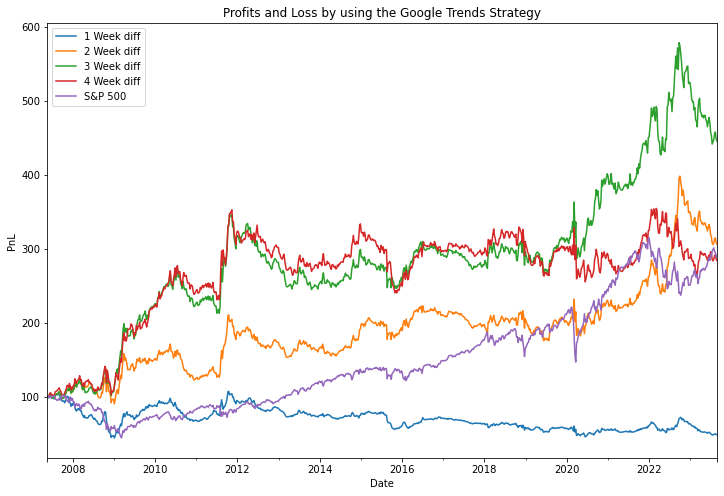

In [32]:
fig, ax = plt.subplots(1, figsize=(12,8))
(np.exp(np.cumsum(SP_return_monday * Signal_debt_diff1.shift(1))) * 100).plot(ax = ax, legend=True, label='1 Week diff') 
(np.exp(np.cumsum(SP_return_monday * Signal_debt_diff2.shift(1))) * 100).plot(ax = ax, legend=True, label='2 Week diff') 
(np.exp(np.cumsum(SP_return_monday * Signal_debt_diff3.shift(1))) * 100).plot(ax = ax, legend=True, label='3 Week diff') 
(np.exp(np.cumsum(SP_return_monday * Signal_debt_diff4.shift(1))) * 100).plot(ax = ax, legend=True, label='4 Week diff') 
(np.exp(np.cumsum(SP_return_monday)) * 100).plot(ax = ax, legend=True, label='S&P 500') 

ax.set_xlabel('Date')
ax.set_ylabel('PnL')
ax.set_title('Profits and Loss by using the Google Trends Strategy')
plt.savefig('PnL_Trends_debt.png')

In [33]:
Debt_trends_friday = Debt_trends.iloc[1:]
Debt_trends_friday.index = Macroeconomics.index # we are going to take back the information 
                                                            # from Sunday to previous Friday
Macro_trends_debt = pd.concat([Macroeconomics, Debt_trends_friday.iloc[:, -4:]], axis=1, join='outer')
Macro_trends_debt

BBB Corp OAS  BBB Corp Yield  AAA Copr OAS  AAA Corp Yield  \
2007-05-25         1.162           6.040         0.600           5.456   
2007-06-01         1.176           6.110         0.612           5.530   
2007-06-08         1.202           6.246         0.620           5.648   
2007-06-15         1.216           6.408         0.624           5.782   
2007-06-22         1.216           6.342         0.628           5.720   
...                  ...             ...           ...             ...   
2023-07-28         1.506           5.790         0.500           4.746   
2023-08-04         1.492           5.868         0.490           4.854   
2023-08-11         1.514           5.892         0.500           4.870   
2023-08-18         1.534           6.068         0.504           5.024   
2023-08-25         1.532           6.098         0.488           5.032   

            Corp Yield  Yield Spread  10Y Breakeven Inflation  \
2007-05-25       2.460        -0.062                    2.364   
2007-06-01       2.436         0.064                    2.362   
2007-06-08       2.464         0.220                    2.398   
2007-06-15       2.504         0.534                    2.438   
2007-06-22       2.612         0.446                    2.422   
...                ...           ...                      ...   
2023-07-28       3.834        -1.592                    2.376   
2023-08-04       3.912        -1.470                    2.370   
2023-08-11       3.914        -1.480                    2.360   
2023-08-18       3.884        -1.310                    2.330   
2023-08-25       3.926        -1.310                    2.338   

            5Y Breakeven Inflation  TED Spread  Fed Rate  ...       Oil  \
2007-05-25                   2.354       0.592     5.250  ...  0.026104   
2007-06-01                   2.338       0.664     5.268  ... -0.016870   
2007-06-08                   2.368       0.688     5.238  ...  0.026262   
2007-06-15                   2.400       0.826     5.266  ...  0.011348   
2007-06-22                   2.380       0.800     5.242  ...  0.032303   
...                            ...         ...       ...  ...       ...   
2023-07-28                   2.266       0.090     5.180  ...  0.051238   
2023-08-04                   2.256       0.090     5.330  ...  0.022887   
2023-08-11                   2.262       0.090     5.330  ...  0.020042   
2023-08-18                   2.244       0.090     5.330  ... -0.026228   
2023-08-25                   2.254       0.090     5.330  ... -0.014141   

                Gold  Financial Stress Index  M2 Money Supply  \
2007-05-25 -0.008138                 -1.0206           7240.9   
2007-06-01  0.001669                 -0.9628           7218.2   
2007-06-08  0.005353                 -0.8547           7286.8   
2007-06-15 -0.017681                 -0.7900           7295.4   
2007-06-22  0.006000                 -0.6962           7305.5   
...              ...                     ...              ...   
2023-07-28 -0.004339                 -0.7902          20709.4   
2023-08-04 -0.007880                 -0.7666          20756.9   
2023-08-11 -0.012412                 -0.6756          20756.9   
2023-08-18 -0.012673                 -0.6683          20756.9   
2023-08-25  0.006110                 -0.7220          20756.9   

            Initial Claims NSA  Initial Claims SA    Diff 1        Diff 2  \
2007-05-25            0.045115           0.042840  0.000000 -2.185087e+00   
2007-06-01            0.010853           0.000000  3.745864  3.745864e+00   
2007-06-08           -0.036769           0.009631 -1.872932  7.105427e-15   
2007-06-15            0.137489           0.000000 -3.121553 -4.058019e+00   
2007-06-22           -0.038490           0.022118  6.243107  4.682330e+00   
...                        ...                ...       ...           ...   
2023-07-28           -0.189992          -0.031183  3.000000  1.000000e+00   
2023-08-04           -0.037933           0.0

In [34]:
# Separating the independent and target variable on both data set
x_train = Debt_trends_friday.loc[:'2021-12-31'].iloc[:-50, -4:]
y_train = VIX_return_increment.loc[:'2022-01-07'].iloc[2:-50]
x_test = Debt_trends_friday.loc[:'2021-12-31'].iloc[-50:, -4:]
y_test = VIX_return_increment.loc[:'2022-01-07'].iloc[-50:]
 
# Creating an object for model and fitting it on training data set
LGBMC_model = LGBMClassifier(boosting_type='gbdt', num_leaves=2, max_depth=2, learning_rate=40, n_estimators=1020,
                             subsample_for_bin=485, objective='binary', min_split_gain=1e-19, min_child_weight=1e-19, 
                             min_child_samples=306, subsample=0.01, colsample_bytree=0.37, reg_alpha=1e-19, reg_lambda=1e5,
                             importance_type='gain')
LGBMC_model.fit(x_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 331, number of negative: 382
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464236 -> initscore=-0.143302
[LightGBM] [Info] Start training from score -0.143302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

LGBMClassifier(colsample_bytree=0.37, importance_type='gain', learning_rate=40,
               max_depth=2, min_child_samples=306, min_child_weight=1e-19,
               min_split_gain=1e-19, n_estimators=1020, num_leaves=2,
               objective='binary', reg_alpha=1e-19, reg_lambda=100000.0,
               subsample=0.01, subsample_for_bin=485)

In [35]:
# Predicting the Target variable
LGBMC_prediction = LGBMC_model.predict(x_test)
print(LGBMC_prediction)
accuracy = LGBMC_model.score(x_test, y_test)
print(accuracy)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.56


In [36]:
# Separating the independent and target variable on both data set
x_train = Macro_trends_debt.loc[:'2021-12-31'].iloc[:-50]
y_train = VIX_return_increment.loc[:'2022-01-07'].iloc[2:-50]
x_test = Macro_trends_debt.loc[:'2021-12-31'].iloc[-50:]
y_test = VIX_return_increment.loc[:'2022-01-07'].iloc[-50:]
 
# Creating an object for model and fitting it on training data set
LGBMC_model = LGBMClassifier(boosting_type='gbdt', num_leaves=2, max_depth=2, learning_rate=40, n_estimators=1020,
                             subsample_for_bin=485, objective='binary', min_split_gain=1e-19, min_child_weight=1e-19, 
                             min_child_samples=306, subsample=0.01, colsample_bytree=0.37, reg_alpha=1e-19, reg_lambda=1e5,
                             importance_type='gain')
LGBMC_model.fit(x_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 331, number of negative: 382
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3990
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464236 -> initscore=-0.143302
[LightGBM] [Info] Start training from score -0.143302


LGBMClassifier(colsample_bytree=0.37, importance_type='gain', learning_rate=40,
               max_depth=2, min_child_samples=306, min_child_weight=1e-19,
               min_split_gain=1e-19, n_estimators=1020, num_leaves=2,
               objective='binary', reg_alpha=1e-19, reg_lambda=100000.0,
               subsample=0.01, subsample_for_bin=485)

In [37]:
# Predicting the Target variable
LGBMC_prediction = LGBMC_model.predict(x_test)
print(LGBMC_prediction)
accuracy = LGBMC_model.score(x_test, y_test)
print(accuracy)

[0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 1]
0.54


## S&P

In [38]:
# Now we are going to focus on the word S&P
kw_list = ['S&P'] 
#pytrends only allow us to download data in a 5Y window, so we are going to merge different queries
pytrends.build_payload(kw_list, cat=0, timeframe='2007-04-28 2010-01-07', geo='', gprop='')
SP_1 = pytrends.interest_over_time()['S&P']
pytrends.build_payload(kw_list, cat=0, timeframe='2010-01-01 2015-01-07', geo='', gprop='')
SP_2 = pytrends.interest_over_time()['S&P']
pytrends.build_payload(kw_list, cat=0, timeframe='2015-01-01 2020-01-07', geo='', gprop='')
SP_3 = pytrends.interest_over_time()['S&P']
pytrends.build_payload(kw_list, cat=0, timeframe='2020-01-01 2023-09-01', geo='', gprop='')
SP_4 = pytrends.interest_over_time()['S&P']

# Normalie overall periods
SP_4 = SP_4.astype(float)
SP_3 = SP_3 / SP_3[-1]  * SP_4[0]
SP_2 = SP_2 / SP_2[-1]  * SP_3[0]
SP_1 = SP_1 / SP_1[-1]  * SP_2[0]

SP_trends = pd.DataFrame(pd.concat([SP_1[:-1], SP_2[:-1], SP_3[:-1], SP_4], axis=0, join='outer'))

In [39]:
SP_trends['2W average'] = SP_trends['S&P'].rolling(2).mean()
SP_trends['3W average'] = SP_trends['S&P'].rolling(3).mean()
SP_trends['4W average'] = SP_trends['S&P'].rolling(4).mean()
SP_trends['Diff 1'] = SP_trends['S&P'].diff(1)
SP_trends['Diff 2'] = SP_trends['S&P'] - SP_trends['2W average'].shift(1)
SP_trends['Diff 3'] = SP_trends['S&P'] - SP_trends['3W average'].shift(1)
SP_trends['Diff 4'] = SP_trends['S&P'] - SP_trends['4W average'].shift(1)
SP_trends.drop(SP_trends.index[:3], inplace=True)

SP_trends.index = Mondays

In [40]:
Signal_SP_diff1 = 2 * (SP_trends['Diff 1'] < 0) - 1
Signal_SP_diff2 = 2 * (SP_trends['Diff 2'] < 0) - 1
Signal_SP_diff3 = 2 * (SP_trends['Diff 3'] < 0) - 1
Signal_SP_diff4 = 2 * (SP_trends['Diff 4'] < 0) - 1

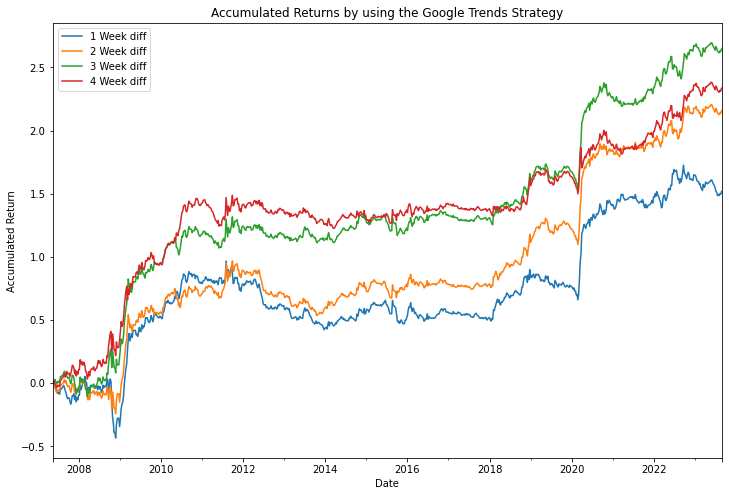

In [41]:
fig, ax = plt.subplots(1, figsize=(12,8))
(np.cumsum(SP_return_monday * Signal_SP_diff1.shift(1))).plot(ax = ax, legend=True, label='1 Week diff') 
(np.cumsum(SP_return_monday * Signal_SP_diff2.shift(1))).plot(ax = ax, legend=True, label='2 Week diff') 
(np.cumsum(SP_return_monday * Signal_SP_diff3.shift(1))).plot(ax = ax, legend=True, label='3 Week diff') 
(np.cumsum(SP_return_monday * Signal_SP_diff4.shift(1))).plot(ax = ax, legend=True, label='4 Week diff') 
ax.set_xlabel('Date')
ax.set_ylabel('Accumulated Return')
ax.set_title('Accumulated Returns by using the Google Trends Strategy')
plt.savefig('Accumulated_Returns_Trends_SP.png')

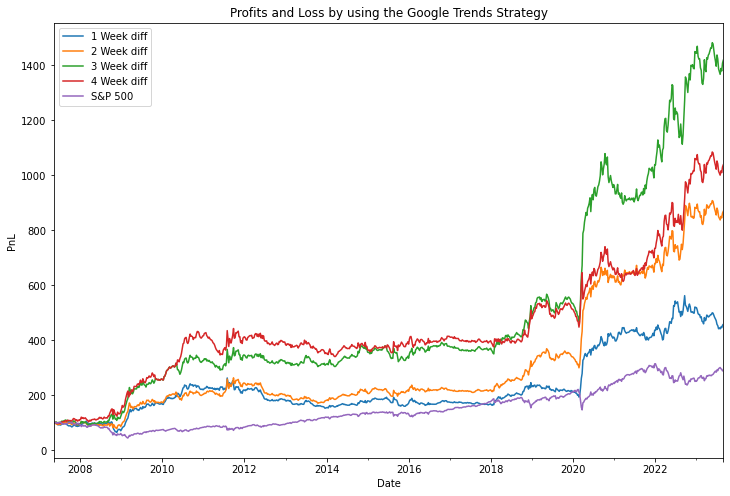

In [42]:
fig, ax = plt.subplots(1, figsize=(12,8))
(np.exp(np.cumsum(SP_return_monday * Signal_SP_diff1.shift(1))) * 100).plot(ax = ax, legend=True, label='1 Week diff') 
(np.exp(np.cumsum(SP_return_monday * Signal_SP_diff2.shift(1))) * 100).plot(ax = ax, legend=True, label='2 Week diff') 
(np.exp(np.cumsum(SP_return_monday * Signal_SP_diff3.shift(1))) * 100).plot(ax = ax, legend=True, label='3 Week diff') 
(np.exp(np.cumsum(SP_return_monday * Signal_SP_diff4.shift(1))) * 100).plot(ax = ax, legend=True, label='4 Week diff') 
(np.exp(np.cumsum(SP_return_monday)) * 100).plot(ax = ax, legend=True, label='S&P 500') 

ax.set_xlabel('Date')
ax.set_ylabel('PnL')
ax.set_title('Profits and Loss by using the Google Trends Strategy')
plt.savefig('PnL_Trends_SP.png')

In [43]:
SP_trends_friday = SP_trends.iloc[1:]
SP_trends_friday.index = Macroeconomics.index # we are going to take back the information 
                                                            # from Sunday to previous Friday
Macro_trends_SP = pd.concat([Macroeconomics, SP_trends_friday.iloc[:, -4:]], axis=1, join='outer')
Macro_trends_SP

BBB Corp OAS  BBB Corp Yield  AAA Copr OAS  AAA Corp Yield  \
2007-05-25         1.162           6.040         0.600           5.456   
2007-06-01         1.176           6.110         0.612           5.530   
2007-06-08         1.202           6.246         0.620           5.648   
2007-06-15         1.216           6.408         0.624           5.782   
2007-06-22         1.216           6.342         0.628           5.720   
...                  ...             ...           ...             ...   
2023-07-28         1.506           5.790         0.500           4.746   
2023-08-04         1.492           5.868         0.490           4.854   
2023-08-11         1.514           5.892         0.500           4.870   
2023-08-18         1.534           6.068         0.504           5.024   
2023-08-25         1.532           6.098         0.488           5.032   

            Corp Yield  Yield Spread  10Y Breakeven Inflation  \
2007-05-25       2.460        -0.062                    2.364   
2007-06-01       2.436         0.064                    2.362   
2007-06-08       2.464         0.220                    2.398   
2007-06-15       2.504         0.534                    2.438   
2007-06-22       2.612         0.446                    2.422   
...                ...           ...                      ...   
2023-07-28       3.834        -1.592                    2.376   
2023-08-04       3.912        -1.470                    2.370   
2023-08-11       3.914        -1.480                    2.360   
2023-08-18       3.884        -1.310                    2.330   
2023-08-25       3.926        -1.310                    2.338   

            5Y Breakeven Inflation  TED Spread  Fed Rate  ...       Oil  \
2007-05-25                   2.354       0.592     5.250  ...  0.026104   
2007-06-01                   2.338       0.664     5.268  ... -0.016870   
2007-06-08                   2.368       0.688     5.238  ...  0.026262   
2007-06-15                   2.400       0.826     5.266  ...  0.011348   
2007-06-22                   2.380       0.800     5.242  ...  0.032303   
...                            ...         ...       ...  ...       ...   
2023-07-28                   2.266       0.090     5.180  ...  0.051238   
2023-08-04                   2.256       0.090     5.330  ...  0.022887   
2023-08-11                   2.262       0.090     5.330  ...  0.020042   
2023-08-18                   2.244       0.090     5.330  ... -0.026228   
2023-08-25                   2.254       0.090     5.330  ... -0.014141   

                Gold  Financial Stress Index  M2 Money Supply  \
2007-05-25 -0.008138                 -1.0206           7240.9   
2007-06-01  0.001669                 -0.9628           7218.2   
2007-06-08  0.005353                 -0.8547           7286.8   
2007-06-15 -0.017681                 -0.7900           7295.4   
2007-06-22  0.006000                 -0.6962           7305.5   
...              ...                     ...              ...   
2023-07-28 -0.004339                 -0.7902          20709.4   
2023-08-04 -0.007880                 -0.7666          20756.9   
2023-08-11 -0.012412                 -0.6756          20756.9   
2023-08-18 -0.012673                 -0.6683          20756.9   
2023-08-25  0.006110                 -0.7220          20756.9   

            Initial Claims NSA  Initial Claims SA    Diff 1        Diff 2  \
2007-05-25            0.045115           0.042840  0.220394  5.509839e-01   
2007-06-01            0.010853           0.000000 -0.220394 -1.101968e-01   
2007-06-08           -0.036769           0.009631  0.220394  1.101968e-01   
2007-06-15            0.137489           0.000000 -0.440787 -3.305903e-01   
2007-06-22           -0.038490           0.022118  0.000000 -2.203936e-01   
...                        ...                ...       ...           ...   
2023-07-28           -0.189992          -0.031183  1.000000  1.500000e+00   
2023-08-04           -0.037933           0.0

In [44]:
# Separating the independent and target variable on both data set
x_train = SP_trends_friday.loc[:'2021-12-31'].iloc[:-50, -4:]
y_train = VIX_return_increment.loc[:'2022-01-07'].iloc[2:-50]
x_test = SP_trends_friday.loc[:'2021-12-31'].iloc[-50:, -4:]
y_test = VIX_return_increment.loc[:'2022-01-07'].iloc[-50:]
 
# Creating an object for model and fitting it on training data set
LGBMC_model = LGBMClassifier(boosting_type='gbdt', num_leaves=2, max_depth=2, learning_rate=40, n_estimators=1020,
                             subsample_for_bin=485, objective='binary', min_split_gain=1e-19, min_child_weight=1e-19, 
                             min_child_samples=306, subsample=0.01, colsample_bytree=0.37, reg_alpha=1e-19, reg_lambda=1e5,
                             importance_type='gain')
LGBMC_model.fit(x_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 331, number of negative: 382
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464236 -> initscore=-0.143302
[LightGBM] [Info] Start training from score -0.143302


LGBMClassifier(colsample_bytree=0.37, importance_type='gain', learning_rate=40,
               max_depth=2, min_child_samples=306, min_child_weight=1e-19,
               min_split_gain=1e-19, n_estimators=1020, num_leaves=2,
               objective='binary', reg_alpha=1e-19, reg_lambda=100000.0,
               subsample=0.01, subsample_for_bin=485)

In [45]:
# Predicting the Target variable
LGBMC_prediction = LGBMC_model.predict(x_test)
print(LGBMC_prediction)
accuracy = LGBMC_model.score(x_test, y_test)
print(accuracy)

[1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 1 0 1 1 0 1
 0 0 0 0 0 0 0 1 0 0 0 1 1]
0.68


In [46]:
# Separating the independent and target variable on both data set
x_train = Macro_trends_SP.loc[:'2021-12-31'].iloc[:-50, :-4]
y_train = VIX_return_increment.loc[:'2022-01-07'].iloc[2:-50]
x_test = Macro_trends_SP.loc[:'2021-12-31'].iloc[-50:, :-4]
y_test = VIX_return_increment.loc[:'2022-01-07'].iloc[-50:]
 
# Creating an object for model and fitting it on training data set
LGBMC_model.fit(x_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 331, number of negative: 382
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3472
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464236 -> initscore=-0.143302
[LightGBM] [Info] Start training from score -0.143302


LGBMClassifier(colsample_bytree=0.37, importance_type='gain', learning_rate=40,
               max_depth=2, min_child_samples=306, min_child_weight=1e-19,
               min_split_gain=1e-19, n_estimators=1020, num_leaves=2,
               objective='binary', reg_alpha=1e-19, reg_lambda=100000.0,
               subsample=0.01, subsample_for_bin=485)

In [47]:
# Predicting the Target variable
LGBMC_prediction = LGBMC_model.predict(x_test)
print(LGBMC_prediction)
accuracy = LGBMC_model.score(x_test, y_test)
print(accuracy)

[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 1 1 0 0 0 0 0 0 1 0 1 1]
0.56


### Combine information

In [48]:
Trends_friday = pd.concat([Debt_trends_friday.iloc[:,-4:], SP_trends_friday.iloc[:,-4:]], axis=1)
Trends_friday

Diff 1        Diff 2        Diff 3    Diff 4    Diff 1  \
2007-05-25  0.000000 -2.185087e+00 -2.913450e+00 -4.526252  0.220394   
2007-06-01  3.745864  3.745864e+00  2.289139e+00  1.560777 -0.220394   
2007-06-08 -1.872932  7.105427e-15  6.243107e-01 -0.156078  0.220394   
2007-06-15 -3.121553 -4.058019e+00 -3.121553e+00 -2.653320 -0.440787   
2007-06-22  6.243107  4.682330e+00  3.537760e+00  3.901942  0.000000   
...              ...           ...           ...       ...       ...   
2023-07-28  3.000000  1.000000e+00  7.105427e-15  0.250000  1.000000   
2023-08-04  0.000000  1.500000e+00  6.666667e-01  0.000000 -2.000000   
2023-08-11 -3.000000 -3.000000e+00 -2.000000e+00 -2.500000  1.000000   
2023-08-18  4.000000  2.500000e+00  2.000000e+00  2.500000 -3.000000   
2023-08-25  2.000000  4.000000e+00  3.666667e+00  3.500000  5.000000   

                  Diff 2    Diff 3    Diff 4  
2007-05-25  5.509839e-01 -0.220394 -0.440787  
2007-06-01 -1.101968e-01  0.146929 -0.385689  
2007-06-08  1.101968e-01  0.146929  0.330590  
2007-06-15 -3.305903e-01 -0.367323 -0.330590  
2007-06-22 -2.203936e-01 -0.220394 -0.275492  
...                  ...       ...       ...  
2023-07-28  1.500000e+00  1.333333  2.750000  
2023-08-04 -1.500000e+00 -1.000000 -1.000000  
2023-08-11  7.105427e-15  0.000000  0.250000  
2023-08-18 -2.500000e+00 -3.000000 -3.000000  
2023-08-25  3.500000e+00  3.333333  2.750000  

[849 rows x 8 columns]

In [49]:
# Separating the independent and target variable on both data set
x_train = Trends_friday.loc[:'2021-12-31'].iloc[:-50, -4:]
y_train = VIX_return_increment.loc[:'2022-01-07'].iloc[2:-50]
x_test = Trends_friday.loc[:'2021-12-31'].iloc[-50:, -4:]
y_test = VIX_return_increment.loc[:'2022-01-07'].iloc[-50:]
 
# Creating an object for model and fitting it on training data set
LGBMC_model = LGBMClassifier(boosting_type='gbdt', num_leaves=2, max_depth=2, learning_rate=40, n_estimators=1020,
                             subsample_for_bin=485, objective='binary', min_split_gain=1e-19, min_child_weight=1e-19, 
                             min_child_samples=306, subsample=0.01, colsample_bytree=0.37, reg_alpha=1e-19, reg_lambda=1e5,
                             importance_type='gain')
LGBMC_model.fit(x_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 331, number of negative: 382
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464236 -> initscore=-0.143302
[LightGBM] [Info] Start training from score -0.143302


LGBMClassifier(colsample_bytree=0.37, importance_type='gain', learning_rate=40,
               max_depth=2, min_child_samples=306, min_child_weight=1e-19,
               min_split_gain=1e-19, n_estimators=1020, num_leaves=2,
               objective='binary', reg_alpha=1e-19, reg_lambda=100000.0,
               subsample=0.01, subsample_for_bin=485)

In [50]:
# Predicting the Target variable
LGBMC_prediction = LGBMC_model.predict(x_test)
print(LGBMC_prediction)
accuracy = LGBMC_model.score(x_test, y_test)
print(accuracy)

[1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 1 0 1 1 0 1
 0 0 0 0 0 0 0 1 0 0 0 1 1]
0.68


## Forecasting Increments on S&P 500

In [51]:
SP_return_increment = (SP_return_monday > 0) + 0

In [52]:
# Separating the independent and target variable on both data set
x_train = Macro_trends_SP.loc[:'2021-12-31'].iloc[:-50, :-4]
y_train = SP_return_increment.loc[:'2022-01-10'].iloc[2:-50]
x_test = Macro_trends_SP.loc[:'2021-12-31'].iloc[-50:, :-4]
y_test = SP_return_increment.loc[:'2022-01-10'].iloc[-50:]
 
# Creating an object for model and fitting it on training data set
LGBMC_model = LGBMClassifier(boosting_type='gbdt', num_leaves=2, max_depth=2, learning_rate=40, n_estimators=1020,
                             subsample_for_bin=485, objective='binary', min_split_gain=1e-19, min_child_weight=1e-19, 
                             subsample=0.01, colsample_bytree=0.37, reg_alpha=1e-19, reg_lambda=1e5,
                             importance_type='gain')
LGBMC_model.fit(x_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 414, number of negative: 299
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3472
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580645 -> initscore=0.325422
[LightGBM] [Info] Start training from score 0.325422


LGBMClassifier(colsample_bytree=0.37, importance_type='gain', learning_rate=40,
               max_depth=2, min_child_weight=1e-19, min_split_gain=1e-19,
               n_estimators=1020, num_leaves=2, objective='binary',
               reg_alpha=1e-19, reg_lambda=100000.0, subsample=0.01,
               subsample_for_bin=485)

In [53]:
# Predicting the Target variable
LGBMC_prediction = LGBMC_model.predict(x_test)
print(LGBMC_prediction)
accuracy = LGBMC_model.score(x_test, y_test)
print(accuracy)

[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.6


In [54]:
# Separating the independent and target variable on both data set
x_train = Macro_trends_SP.loc[:'2021-12-31'].iloc[:-50]
y_train = SP_return_increment.loc[:'2022-01-10'].iloc[2:-50]
x_test = Macro_trends_SP.loc[:'2021-12-31'].iloc[-50:]
y_test = SP_return_increment.loc[:'2022-01-10'].iloc[-50:]
 
# Creating an object for model and fitting it on training data set
LGBMC_model = LGBMClassifier(boosting_type='gbdt', num_leaves=2, max_depth=2, learning_rate=40, n_estimators=1020,
                             subsample_for_bin=485, objective='binary', min_split_gain=1e-19, min_child_weight=1e-19, 
                             subsample=0.01, colsample_bytree=0.37, reg_alpha=1e-19, reg_lambda=1e5,
                             importance_type='gain')
LGBMC_model.fit(x_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 414, number of negative: 299
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3987
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580645 -> initscore=0.325422
[LightGBM] [Info] Start training from score 0.325422


LGBMClassifier(colsample_bytree=0.37, importance_type='gain', learning_rate=40,
               max_depth=2, min_child_weight=1e-19, min_split_gain=1e-19,
               n_estimators=1020, num_leaves=2, objective='binary',
               reg_alpha=1e-19, reg_lambda=100000.0, subsample=0.01,
               subsample_for_bin=485)

In [55]:
# Predicting the Target variable
LGBMC_prediction = LGBMC_model.predict(x_test)
print(LGBMC_prediction)
accuracy = LGBMC_model.score(x_test, y_test)
print(accuracy)

[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.6


# Forecasting increase-decrease with 5Y data

### Predicting change in VIX using macroeconomic variables

In [56]:
Macroeconomics_predictions = []

for i in range(260, Macroeconomics.shape[0] - 2):
# Separating the independent and target variable on both data set
    x_train = Macroeconomics.iloc[i - 260: i, :]
    y_train = VIX_return_increment.iloc[i - 258: i + 2]
    x_test = Macroeconomics.iloc[i + 1]
    y_test = VIX_return_increment.iloc[i + 3]

    # Creating an object for model and fitting it on training data set
    LGBMC_model = LGBMClassifier(boosting_type='gbdt', num_leaves=2, max_depth=2, learning_rate=40, n_estimators=1020,
                             subsample_for_bin=485, objective='binary', min_split_gain=1e-19, min_child_weight=1e-19, 
                             subsample=0.01, colsample_bytree=0.37, reg_alpha=1e-19, reg_lambda=1e5,
                             importance_type='gain')
    LGBMC_model.fit(x_train, y_train)

    # Predicting the Target variable
    Macroeconomics_predictions.append(LGBMC_model.predict([x_test]))
    
Macroeconomics_predictions_VIX = pd.DataFrame(Macroeconomics_predictions, index=VIX_return_increment.index[263:], 
                                          columns=['Predicted_VIX_Macroeconomics'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1876
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0.123233
[LightGBM] [Info] Start training from score -0.123233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1872
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1865
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461538 -> initscore=-0.154151
[LightGBM] [Info] Start training from score -0.154151
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1864
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457692 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1862
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457692 -> initscore=-0.169636
[LightGBM] [Info] Start training from score -0.169636
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1865
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1855
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1862
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1856
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1851
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.442308 -> initscore=-0.231802
[LightGBM] [Info] Start training from score -0.231802
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 116, number of negative: 144
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1841
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.446154 -> initscore=-0.216223
[LightGBM] [Info] Start training from score -0.216223
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 115, number of negative: 145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remo

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 116, number of negative: 144
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1834
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.446154 -> initscore=-0.216223
[LightGBM] [Info] Start training from score -0.216223
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0.200671
[LightGBM] [Info] Start training from score -0.200671
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 121, number of negative: 139
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1820
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465385 -> initscore=-0.138683
[LightGBM] [Info] Start training from score -0.138683
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0.123233
[LightGBM] [Info] Start training from score -0.123233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1814
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0.076961
[LightGBM] [Info] Start training from score -0.076961
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1814
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1813
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0.076961
[LightGBM] [Info] Start training from score -0.076961
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1812
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1807
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0

[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1812
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484615 -> initscore=-0.061558
[LightGBM] [Info] Start training from score -0.061558
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1811
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484615 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1805
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0.076961
[LightGBM] [Info] Start training from score -0.076961
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1810
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1813
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1814
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0

[LightGBM] [Info] Number of positive: 121, number of negative: 139
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1819
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465385 -> initscore=-0.138683
[LightGBM] [Info] Start training from score -0.138683
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461538 -> initscore=-0

[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1814
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0

[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0.076961
[LightGBM] [Info] Start training from score -0.076961
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484615 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1812
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484615 -> initscore=-0.061558
[LightGBM] [Info] Start training from score -0.061558
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1811
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1812
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1810
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0.076961
[LightGBM] [Info] Start training from score -0.076961
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1819
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0.076961
[LightGBM] [Info] Start training from score -0.076961
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0

[LightGBM] [Info] Number of positive: 121, number of negative: 139
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465385 -> initscore=-0.138683
[LightGBM] [Info] Start training from score -0.138683
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 121, number of negative: 139
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465385 -> initscore=-0

[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1820
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0.123233
[LightGBM] [Info] Start training from score -0.123233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0

[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0

[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0

[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 115, number of negative: 145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.442308 -> initscore=-0.231802
[LightGBM] [Info] Start training from score -0.231802
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 116, number of negative: 144
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1832
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0.200671
[LightGBM] [Info] Start training from score -0.200671
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0

[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0

[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457692 -> initscore=-0

[LightGBM] [Info] Number of positive: 116, number of negative: 144
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1813
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.446154 -> initscore=-0.216223
[LightGBM] [Info] Start training from score -0.216223
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1813
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0

[LightGBM] [Info] Start training from score -0.263045
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 113, number of negative: 147
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1813
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.434615 -> initscore=-0.263045
[LightGBM] [Info] Start training from score -0.263045
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 112, number of negative: 148
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1810
[LightGBM] [Info] Number of d

[LightGBM] [Info] Number of positive: 110, number of negative: 150
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1811
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.423077 -> initscore=-0.310155
[LightGBM] [Info] Start training from score -0.310155
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 111, number of negative: 149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1811
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.426923 -> initscore=-0

In [57]:
# Accuracy of predictions in all period
(VIX_return_increment.iloc[263:] == Macroeconomics_predictions_VIX['Predicted_VIX_Macroeconomics']).sum() / Macroeconomics_predictions_VIX.shape[0]

0.514480408858603

### Predicting change in VIX using macroeconomic variables and Trends (debt)

In [58]:
Macro_trends_debt_predictions = []

for i in range(260, Macro_trends_debt.shape[0] - 2):
# Separating the independent and target variable on both data set
    x_train = Macro_trends_debt.iloc[i - 260: i, :]
    y_train = VIX_return_increment.iloc[i - 258: i + 2]
    x_test = Macro_trends_debt.iloc[i + 1]
    y_test = VIX_return_increment.iloc[i + 3]

    # Creating an object for model and fitting it on training data set
    LGBMC_model = LGBMClassifier(boosting_type='gbdt', num_leaves=2, max_depth=2, learning_rate=40, n_estimators=1020,
                             subsample_for_bin=485, objective='binary', min_split_gain=1e-19, min_child_weight=1e-19, 
                             subsample=0.01, colsample_bytree=0.37, reg_alpha=1e-19, reg_lambda=1e5,
                             importance_type='gain')
    LGBMC_model.fit(x_train, y_train)

    # Predicting the Target variable
    Macro_trends_debt_predictions.append(LGBMC_model.predict([x_test]))
    
Macro_trends_debt_predictions_VIX = pd.DataFrame(Macro_trends_debt_predictions, index=VIX_return_increment.index[263:], 
                                          columns=['Predicted_VIX_Macro_trends_debt'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0.123233
[LightGBM] [Info] Start training from score -0.123233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2144
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2127
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457692 -> initscore=-0.169636
[LightGBM] [Info] Start training from score -0.169636
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2127
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2125
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0.200671
[LightGBM] [Info] Start training from score -0.200671
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2125
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2103
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461538 -> initscore=-0.154151
[LightGBM] [Info] Start training from score -0.154151
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2107
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457692 -> initscore=-0.169636
[LightGBM] [Info] Start training from score -0.169636
[Ligh

[LightGBM] [Info] Total Bins 2096
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461538 -> initscore=-0.154151
[LightGBM] [Info] Start training from score -0.154151
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2090
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457692 -> initscore=-0.169636
[LightGBM] [Info] Start training from score -0.169636
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Au

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2073
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0.200671
[LightGBM] [Info] Start training from score -0.200671
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2071
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2054
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2053
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2029
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461538 -> initscore=-0.154151
[LightGBM] [Info] Start training from score -0.154151
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2028
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2019
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0.123233
[LightGBM] [Info] Start training from score -0.123233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2018
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2016
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2018
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2034
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0.076961
[LightGBM] [Info] Start training from score -0.076961
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2034
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484615 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2039
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2039
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0.076961
[LightGBM] [Info] Start training from score -0.076961
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2057
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0

[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2061
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0.076961
[LightGBM] [Info] Start training from score -0.076961
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2066
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2066
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2075
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2076
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461538 -> initscore=-0.154151
[LightGBM] [Info] Start training from score -0.154151
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 121, number of negative: 139
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2081
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2084
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0

[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2082
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0.076961
[LightGBM] [Info] Start training from score -0.076961
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2083
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484615 -> initscore=-0

[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484615 -> initscore=-0.061558
[LightGBM] [Info] Start training from score -0.061558
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2090
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2090
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2090
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0.076961
[LightGBM] [Info] Start training from score -0.076961
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2087
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2085
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2086
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0.076961
[LightGBM] [Info] Start training from score -0.076961
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2084
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 121, number of negative: 139
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2086
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465385 -> initscore=-0.138683
[LightGBM] [Info] Start training from score -0.138683
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 121, number of negative: 139
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2083
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2083
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0.123233
[LightGBM] [Info] Start training from score -0.123233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2081
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0

[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2093
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2094
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457692 -> initscore=-0.169636
[LightGBM] [Info] Start training from score -0.169636
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2093
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 115, number of negative: 145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2081
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.442308 -> initscore=-0.231802
[LightGBM] [Info] Start training from score -0.231802
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 115, number of negative: 145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2082
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2073
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0.200671
[LightGBM] [Info] Start training from score -0.200671
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2075
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2068
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2068
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2056
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457692 -> initscore=-0.169636
[LightGBM] [Info] Start training from score -0.169636
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2058
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 116, number of negative: 144
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2047
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.446154 -> initscore=-0.216223
[LightGBM] [Info] Start training from score -0.216223
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 116, number of negative: 144
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2050
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.446154 -> initscore=-0

[LightGBM] [Info] Number of positive: 112, number of negative: 148
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2037
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.430769 -> initscore=-0.278713
[LightGBM] [Info] Start training from score -0.278713
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 111, number of negative: 149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.426923 -> initscore=-0

[LightGBM] [Info] Number of positive: 112, number of negative: 148
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2030
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.430769 -> initscore=-0.278713
[LightGBM] [Info] Start training from score -0.278713
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 112, number of negative: 148
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2029
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.430769 -> initscore=-0

In [59]:
# Accuracy of predictions in all period
(VIX_return_increment.iloc[263:] == Macro_trends_debt_predictions_VIX['Predicted_VIX_Macro_trends_debt']).sum() / Macro_trends_debt_predictions_VIX.shape[0]

0.5212947189097104

In [60]:
# Only using Trends on debt
Trends_debt_predictions = []

for i in range(260, Debt_trends_friday.shape[0] - 2):
# Separating the independent and target variable on both data set
    x_train = Debt_trends_friday.iloc[i - 260: i, -4:]
    y_train = VIX_return_increment.iloc[i - 258: i + 2]
    x_test = Debt_trends_friday.iloc[i + 1, -4:]
    y_test = VIX_return_increment.iloc[i + 3]

    # Creating an object for model and fitting it on training data set
    LGBMC_model = LGBMClassifier(boosting_type='gbdt', num_leaves=2, max_depth=2, learning_rate=40, n_estimators=1020,
                             subsample_for_bin=485, objective='binary', min_debtlit_gain=1e-19, min_child_weight=1e-19, 
                             subsample=0.01, colsample_bytree=0.37, reg_alpha=1e-19, reg_lambda=1e5,
                             importance_type='gain')
    LGBMC_model.fit(x_train, y_train)

    # Predicting the Target variable
    Trends_debt_predictions.append(LGBMC_model.predict([x_test]))
    
Trends_debt_predictions_VIX = pd.DataFrame(Trends_debt_predictions, index=VIX_return_increment.index[263:], 
                                          columns=['Predicted_VIX_Trends_debt'])

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0.123233
[LightGBM] [Info] Start training from score -0.123233
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 122, number of negative: 138

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461538 -> initscore=-0.154151
[LightGBM] [Info] Start training from score -0.154151
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 119, number of negative: 141

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457692 -> initscore=-0.169636
[LightGBM] [Info] Start training from score -0.169636
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 119, number of negative: 141

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461538 -> initscore=-0.154151
[LightGBM] [Info] Start training from score -0.154151
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 115, number of negative: 145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.442308 -> initscore=-0.231802
[LightGBM] [Info] Start training from score -0.231802
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 114, number of negative: 146

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0.200671
[LightGBM] [Info] Start training from score -0.200671
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 221
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0.200671
[LightGBM] [Info] Start training from score -0.200671
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 117, number of negative: 143

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461538 -> initscore=-0.154151
[LightGBM] [Info] Start training from score -0.154151
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 121, number of negative: 139
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465385 -> initscore=-0.138683
[LightGBM] [Info] Start training from score -0.138683
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM

[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[Li

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 223
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0.076961
[LightGBM] [Info] Start training from score -0.076961
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 125, number of negative: 135

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 124, number of negative: 136

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 127, number of negative: 133
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 243
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488462 -> initscore=-0.046162
[LightGBM] [Info] Start training from score -0.046162
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484615 -> initscore=-0.061558
[LightGBM] [Info] Start training from score -0.061558
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 127, number of negative: 133

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 248
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 122, number of negative: 138

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0.123233
[LightGBM] [Info] Start training from score -0.123233
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[L

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 275
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484615 -> initscore=-0.061558
[LightGBM] [Info] Start training from score -0.061558
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 126, number of negative: 134

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 275
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 279
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 123, number of negative: 137

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0.076961
[LightGBM] [Info] Start training from score -0.076961
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 123, number of negative: 137

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 124, number of negative: 136

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 122, number of negative: 138

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 121, number of negative: 139
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465385 -> initscore=-0.138683
[LightGBM] [Info] Start training from score -0.138683
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-thread

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461538 -> initscore=-0.154151
[LightGBM] [Info] Start training from score -0.154151
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 119, number of negative: 141

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0.200671
[LightGBM] [Info] Start training from score -0.200671
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 117, number of negative: 143

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 118, number of negative: 142

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0.200671
[LightGBM] [Info] Start training from score -0.200671
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 117, number of negative: 143

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 115, number of negative: 145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.442308 -> initscore=-0.231802
[LightGBM] [Info] Start training from score -0.231802
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 115, number of negative: 145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 248
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.442308 -> initscore=-0.231802
[LightGBM] [Info] Start training from score -0.231802
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 116, number of negative: 144

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457692 -> initscore=-0.169636
[LightGBM] [Info] Start training from score -0.169636
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-thread

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461538 -> initscore=-0.154151
[LightGBM] [Info] Start training from score -0.154151
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=t

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 113, number of negative: 147
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.434615 -> initscore=-0.263045
[LightGBM] [Info] Start training from score -0.263045
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 113, number of negative: 147

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 112, number of negative: 148
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.430769 -> initscore=-0.278713
[LightGBM] [Info] Start training from score -0.278713
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 111, number of negative: 149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.426923 -> initscore=-0.294416
[LightGBM] [Info] Start training from score -0.294416
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 111, number of negative: 149

[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 112, number of negative: 148
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 221
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.430769 -> initscore=-0.278713
[LightGBM] [Info] Start training from score -0.278713
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_debtlit_gain
[LightGBM] [Info] Number of positive: 112, number of negative: 148

In [61]:
# Accuracy of predictions in all period
(VIX_return_increment.iloc[263:] == Trends_debt_predictions_VIX['Predicted_VIX_Trends_debt']).sum() / Trends_debt_predictions_VIX.shape[0]

0.5332197614991482

### Predicting change in VIX using macroeconomic variables and Trends (S&P)

In [62]:
Macro_trends_SP_predictions = []

for i in range(260, Macro_trends_SP.shape[0] - 2):
# Separating the independent and target variable on both data set
    x_train = Macro_trends_SP.iloc[i - 260: i, :]
    y_train = VIX_return_increment.iloc[i - 258: i + 2]
    x_test = Macro_trends_SP.iloc[i + 1]
    y_test = VIX_return_increment.iloc[i + 3]

    # Creating an object for model and fitting it on training data set
    LGBMC_model = LGBMClassifier(boosting_type='gbdt', num_leaves=2, max_depth=2, learning_rate=40, n_estimators=1020,
                             subsample_for_bin=485, objective='binary', min_split_gain=1e-19, min_child_weight=1e-19, 
                             subsample=0.01, colsample_bytree=0.37, reg_alpha=1e-19, reg_lambda=1e5,
                             importance_type='gain')
    LGBMC_model.fit(x_train, y_train)

    # Predicting the Target variable
    Macro_trends_SP_predictions.append(LGBMC_model.predict([x_test]))
    
Macro_trends_SP_predictions_VIX = pd.DataFrame(Macro_trends_SP_predictions, index=VIX_return_increment.index[263:], 
                                          columns=['Predicted_VIX_Macro_trends_SP'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2135
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0.123233
[LightGBM] [Info] Start training from score -0.123233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2132
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2123
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457692 -> initscore=-0.169636
[LightGBM] [Info] Start training from score -0.169636
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2120
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2112
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461538 -> initscore=-0.154151
[LightGBM] [Info] Start training from score -0.154151
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2113
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457692 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2095
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461538 -> initscore=-0.154151
[LightGBM] [Info] Start training from score -0.154151
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2099
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2085
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461538 -> initscore=-0.154151
[LightGBM] [Info] Start training from score -0.154151
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0.200671
[LightGBM] [Info] Start training from score -0.200671
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2057
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2042
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0.200671
[LightGBM] [Info] Start training from score -0.200671
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2038
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2021
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461538 -> initscore=-0.154151
[LightGBM] [Info] Start training from score -0.154151
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2021
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 121, number of negative: 139
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2005
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465385 -> initscore=-0.138683
[LightGBM] [Info] Start training from score -0.138683
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2009
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0

[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2016
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0.076961
[LightGBM] [Info] Start training from score -0.076961
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2016
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0.076961
[LightGBM] [Info] Start training from score -0.076961
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2018
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484615 -> initscore=-0.061558
[LightGBM] [Info] Start training from score -0.061558
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remo

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2020
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2020
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2038
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0.076961
[LightGBM] [Info] Start training from score -0.076961
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2037
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0

[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2046
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0.123233
[LightGBM] [Info] Start training from score -0.123233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2045
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0.123233
[LightGBM] [Info] Start training from score -0.123233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2053
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2055
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0.076961
[LightGBM] [Info] Start training from score -0.076961
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2053
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2054
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484615 -> initscore=-0.061558
[LightGBM] [Info] Start training from score -0.061558
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2054
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2064
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2064
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2071
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2071
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2077
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2077
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2087
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0

[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2086
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0.123233
[LightGBM] [Info] Start training from score -0.123233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2087
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0

[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2080
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0.123233
[LightGBM] [Info] Start training from score -0.123233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2084
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0

[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457692 -> initscore=-0.169636
[LightGBM] [Info] Start training from score -0.169636
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461538 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2096
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2096
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2106
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0.200671
[LightGBM] [Info] Start training from score -0.200671
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 116, number of negative: 144
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2106
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.446154 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 116, number of negative: 144
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2109
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.446154 -> initscore=-0.216223
[LightGBM] [Info] Start training from score -0.216223
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 115, number of negative: 145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2108
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2099
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2087
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457692 -> initscore=-0.169636
[LightGBM] [Info] Start training from score -0.169636
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2085
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457692 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2076
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461538 -> initscore=-0.154151
[LightGBM] [Info] Start training from score -0.154151
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2078
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

[LightGBM] [Info] Number of positive: 116, number of negative: 144
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2072
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.446154 -> initscore=-0.216223
[LightGBM] [Info] Start training from score -0.216223
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2072
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0

[LightGBM] [Info] Number of positive: 112, number of negative: 148
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2053
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.430769 -> initscore=-0.278713
[LightGBM] [Info] Start training from score -0.278713
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 111, number of negative: 149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2055
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.426923 -> initscore=-0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 112, number of negative: 148
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2044
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.430769 -> initscore=-0.278713
[LightGBM] [Info] Start training from score -0.278713
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 112, number of negative: 148
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2045
[LightGBM] [Info] Number of data points in the train set: 260, number of used featu

In [63]:
# Accuracy of predictions in all period
(VIX_return_increment.iloc[263:] == Macro_trends_SP_predictions_VIX['Predicted_VIX_Macro_trends_SP']).sum() / Macro_trends_SP_predictions_VIX.shape[0]

0.5706984667802385

In [64]:
# Only using Trends on S&P
Trends_SP_predictions = []

for i in range(260, SP_trends_friday.shape[0] - 2):
# Separating the independent and target variable on both data set
    x_train = SP_trends_friday.iloc[i - 260: i, -4:]
    y_train = VIX_return_increment.iloc[i - 258: i + 2]
    x_test = SP_trends_friday.iloc[i + 1, -4:]
    y_test = VIX_return_increment.iloc[i + 3]

    # Creating an object for model and fitting it on training data set
    LGBMC_model = LGBMClassifier(boosting_type='gbdt', num_leaves=2, max_depth=2, learning_rate=40, n_estimators=1020,
                             subsample_for_bin=485, objective='binary', min_split_gain=1e-19, min_child_weight=1e-19, 
                             subsample=0.01, colsample_bytree=0.37, reg_alpha=1e-19, reg_lambda=1e5,
                             importance_type='gain')
    LGBMC_model.fit(x_train, y_train)

    # Predicting the Target variable
    Trends_SP_predictions.append(LGBMC_model.predict([x_test]))
    
Trends_SP_predictions_VIX = pd.DataFrame(Trends_SP_predictions, index=VIX_return_increment.index[263:], 
                                          columns=['Predicted_VIX_Trends_SP'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0.123233
[LightGBM] [Info] Start training from score -0.123233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457692 -> initscore=-0.169636
[LightGBM] [Info] Start training from score -0.169636
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461538 -> initscore=-0.154151
[LightGBM] [Info] Start training from score -0.154151
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461538 -> initscore=-0.154151
[LightGBM] [Info] Start training from score -0.154151
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Info] Number of positive: 115, number of negative: 145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.442308 -> initscore=-0.231802
[LightGBM] [Info] Start training from score -0.231802
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 115, number of negative: 145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.442308 -> initscore=-0.231

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 218
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457692 -> initscore=-0.169

[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0.123

[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 199
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484615 -> initscore=-0.061558
[LightGBM] [Info] Start training from score -0.061558
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 218
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0.076961
[LightGBM] [Info] Start training from score -0.076961
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 218
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484615 -> initscore=-0.061558
[LightGBM] [Info] Start training from score -0.061558
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484615 -> initscore=-0.061

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0.123233
[LightGBM] [Info] Start training from score -0.123233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 121, number of negative: 139
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465385 -> initscore=-0.138

[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092

[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0.123233
[LightGBM] [Info] Start training from score -0.123233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 121, number of negative: 139
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465385 -> initscore=-0.138

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Info] Number of positive: 125, number of negative: 135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480769 -> initscore=-0.076961
[LightGBM] [Info] Start training from score -0.076961
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484615 -> initscore=-0.061

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484615 -> initscore=-0.061558
[LightGBM] [Info] Start training from score -0.061558
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 126, number of negative: 134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 254
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0.123

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473077 -> initscore=-0.107797
[LightGBM] [Info] Start training from score -0.107797
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 254
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 124, number of negative: 136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476923 -> initscore=-0.092373
[LightGBM] [Info] Start training from score -0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123, number of negative: 137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0.123233
[LightGBM] [Info] Start training from score -0.123233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0.123

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469231 -> initscore=-0.123233
[LightGBM] [Info] Start training from score -0.123233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 120, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461538 -> initscore=-0.154151
[LightGBM] [Info] Start training from score -0.154151
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457692 -> initscore=-0.169

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0.200671
[LightGBM] [Info] Start training from score -0.200671
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 116, number of negative: 144
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 275
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0.200671
[LightGBM] [Info] Start training from score -0.200671
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Info] Number of positive: 115, number of negative: 145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.442308 -> initscore=-0.231802
[LightGBM] [Info] Start training from score -0.231802
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 115, number of negative: 145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.442308 -> initscore=-0.231

[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0.200671
[LightGBM] [Info] Start training from score -0.200671
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0.200

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453846 -> initscore=-0.185142
[LightGBM] [Info] Start training from score -0.185142
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 115, number of negative: 145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.442308 -> initscore=-0.231802
[LightGBM] [Info] Start training from score -0.231802
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 114, number of negative: 146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.434615 -> initscore=-0.263045
[LightGBM] [Info] Start training from score -0.263045
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 113, number of negative: 147
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.434615 -> initscore=-0.263045
[LightGBM] [Info] Start training from score -0.263045
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 112, number of negative: 148
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 111, number of negative: 149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.426923 -> initscore=-0.294416
[LightGBM] [Info] Start training from score -0.294416
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 112, number of negative: 148
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 111, number of negative: 149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.426923 -> initscore=-0.294416
[LightGBM] [Info] Start training from score -0.294416
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 110, number of negative: 150
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 260, number of used features

In [65]:
# Accuracy of predictions in all period
(VIX_return_increment.iloc[263:] == Trends_SP_predictions_VIX['Predicted_VIX_Trends_SP']).sum() / Trends_SP_predictions_VIX.shape[0]

0.58603066439523

## Predicting changes in S&P 500

### Predicting change in S&P 500 using macroeconomic variables

In [66]:
Macroeconomics_predictions = []

for i in range(260, Macroeconomics.shape[0] - 2):
# Separating the independent and target variable on both data set
    x_train = Macroeconomics.iloc[i - 260: i, :]
    y_train = SP_return_increment.iloc[i - 258: i + 2]
    x_test = Macroeconomics.iloc[i + 1]
    y_test = SP_return_increment.iloc[i + 3]

    # Creating an object for model and fitting it on training data set
    LGBMC_model = LGBMClassifier(boosting_type='gbdt', num_leaves=2, max_depth=2, learning_rate=40, n_estimators=1020,
                             subsample_for_bin=485, objective='binary', min_split_gain=1e-19, min_child_weight=1e-19, 
                             subsample=0.01, colsample_bytree=0.37, reg_alpha=1e-19, reg_lambda=1e5,
                             importance_type='gain')
    LGBMC_model.fit(x_train, y_train)

    # Predicting the Target variable
    Macroeconomics_predictions.append(LGBMC_model.predict([x_test]))
    
Macroeconomics_predictions = pd.DataFrame(Macroeconomics_predictions, index=SP_return_increment.index[263:], 
                                          columns=['Predicted_SP_Macroeconomics'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 136, number of negative: 124
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1876
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523077 -> initscore=0.092373
[LightGBM] [Info] Start training from score 0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 136, number of negative: 124
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1872
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 138, number of negative: 122
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1864
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530769 -> initscore=0.123233
[LightGBM] [Info] Start training from score 0.123233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 138, number of negative: 122
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1864
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 139, number of negative: 121
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1863
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.534615 -> initscore=0.138683
[LightGBM] [Info] Start training from score 0.138683
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 139, number of negative: 121
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1864
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.534615 -> initscore=0.13

[LightGBM] [Info] Number of positive: 140, number of negative: 120
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1861
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538462 -> initscore=0.154151
[LightGBM] [Info] Start training from score 0.154151
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 141, number of negative: 119
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1852
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542308 -> initscore=0.16

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 144, number of negative: 116
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1847
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553846 -> initscore=0.216223
[LightGBM] [Info] Start training from score 0.216223
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 144, number of negative: 116
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1851
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 151, number of negative: 109
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580769 -> initscore=0.325932
[LightGBM] [Info] Start training from score 0.325932
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 151, number of negative: 109
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 151, number of negative: 109
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580769 -> initscore=0.325932
[LightGBM] [Info] Start training from score 0.325932
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 148, number of negative: 112
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1820
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.569231 -> initscore=0.278713
[LightGBM] [Info] Start training from score 0.278713
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 148, number of negative: 112
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1820
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1816
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573077 -> initscore=0.294416
[LightGBM] [Info] Start training from score 0.294416
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 146, number of negative: 114
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1814
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561538 -> initscore=0.247408
[LightGBM] [Info] Start training from score 0.247408
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 146, number of negative: 114
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1814
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 151, number of negative: 109
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1812
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580769 -> initscore=0.325932
[LightGBM] [Info] Start training from score 0.325932
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 151, number of negative: 109
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580769 -> initscore=0.32

[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1804
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573077 -> initscore=0.294416
[LightGBM] [Info] Start training from score 0.294416
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 148, number of negative: 112
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1804
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.569231 -> initscore=0.27

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 147, number of negative: 113
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.565385 -> initscore=0.263045
[LightGBM] [Info] Start training from score 0.263045
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 147, number of negative: 113
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1811
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1811
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573077 -> initscore=0.294416
[LightGBM] [Info] Start training from score 0.294416
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1814
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 151, number of negative: 109
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1810
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580769 -> initscore=0.325932
[LightGBM] [Info] Start training from score 0.325932
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 152, number of negative: 108
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1811
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592308 -> initscore=0.373514
[LightGBM] [Info] Start training from score 0.373514
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 153, number of negative: 107
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 155, number of negative: 105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1816
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596154 -> initscore=0.389465
[LightGBM] [Info] Start training from score 0.389465
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1811
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592308 -> initscore=0.37

[LightGBM] [Info] Number of positive: 156, number of negative: 104
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1816
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465
[LightGBM] [Info] Start training from score 0.405465
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.603846 -> initscore=0.42

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 158, number of negative: 102
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.607692 -> initscore=0.437622
[LightGBM] [Info] Start training from score 0.437622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 156, number of negative: 104
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1811
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465
[LightGBM] [Info] Start training from score 0.405465
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1813
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1810
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.603846 -> initscore=0.421517
[LightGBM] [Info] Start training from score 0.421517
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 158, number of negative: 102
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1820
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592308 -> initscore=0.373514
[LightGBM] [Info] Start training from score 0.373514
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1816
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.603846 -> initscore=0.421517
[LightGBM] [Info] Start training from score 0.421517
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1819
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.603846 -> initscore=0.42

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.611538 -> initscore=0.453784
[LightGBM] [Info] Start training from score 0.453784
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 158, number of negative: 102
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1819
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615385 -> initscore=0.470004
[LightGBM] [Info] Start training from score 0.470004
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 161, number of negative: 99
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.619231 -> initscore=0.486

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1824
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.611538 -> initscore=0.453784
[LightGBM] [Info] Start training from score 0.453784
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615385 -> initscore=0.470004
[LightGBM] [Info] Start training from score 0.470004
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 161, number of negative: 99
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1826
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.619231 -> initscore=0.486

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 162, number of negative: 98
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623077 -> initscore=0.502629
[LightGBM] [Info] Start training from score 0.502629
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 162, number of negative: 98
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1826
[LightGBM] [Info] Number of data points in the train set: 260, number of used features:

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 165, number of negative: 95
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.634615 -> initscore=0.552069
[LightGBM] [Info] Start training from score 0.552069
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 165, number of negative: 95
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 260, number of used features:

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 169, number of negative: 91
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1832
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650000 -> initscore=0.619039
[LightGBM] [Info] Start training from score 0.619039
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 168, number of negative: 92
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1834
[LightGBM] [Info] Number of data points in the train set: 260, number of used features:

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 167, number of negative: 93
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.642308 -> initscore=0.585394
[LightGBM] [Info] Start training from score 0.585394
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 167, number of negative: 93
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 260, number of used features:

[LightGBM] [Info] Number of positive: 162, number of negative: 98
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1820
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623077 -> initscore=0.502629
[LightGBM] [Info] Start training from score 0.502629
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 162, number of negative: 98
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623077 -> initscore=0.5026

[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615385 -> initscore=0.470004
[LightGBM] [Info] Start training from score 0.470004
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1820
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.611538 -> initscore=0.45

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 156, number of negative: 104
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1811
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465
[LightGBM] [Info] Start training from score 0.405465
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 156, number of negative: 104
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1811
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592308 -> initscore=0.373514
[LightGBM] [Info] Start training from score 0.373514
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 153, number of negative: 107
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592308 -> initscore=0.373514
[LightGBM] [Info] Start training from score 0.373514
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1807
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592308 -> initscore=0.37

In [67]:
# Accuracy of predictions in all period
(SP_return_increment.iloc[263:] == Macroeconomics_predictions['Predicted_SP_Macroeconomics']).sum() / Macroeconomics_predictions.shape[0]

0.5638841567291312

### Predicting change in S&P500 using macroeconomic variables and Trends (debt)

In [68]:
Macro_trends_debt_predictions = []

for i in range(260, Macro_trends_debt.shape[0] - 2):
# Separating the independent and target variable on both data set
    x_train = Macro_trends_debt.iloc[i - 260: i, :]
    y_train = SP_return_increment.iloc[i - 258: i + 2]
    x_test = Macro_trends_debt.iloc[i + 1]
    y_test = SP_return_increment.iloc[i + 3]

    # Creating an object for model and fitting it on training data set
    LGBMC_model = LGBMClassifier(boosting_type='gbdt', num_leaves=2, max_depth=2, learning_rate=40, n_estimators=1020,
                             subsample_for_bin=485, objective='binary', min_split_gain=1e-19, min_child_weight=1e-19, 
                             subsample=0.01, colsample_bytree=0.37, reg_alpha=1e-19, reg_lambda=1e5,
                             importance_type='gain')
    LGBMC_model.fit(x_train, y_train)

    # Predicting the Target variable
    Macro_trends_debt_predictions.append(LGBMC_model.predict([x_test]))
    
Macro_trends_debt_predictions = pd.DataFrame(Macro_trends_debt_predictions, index=SP_return_increment.index[263:], 
                                          columns=['Predicted_SP_Macro_trends_debt'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 136, number of negative: 124
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523077 -> initscore=0.092373
[LightGBM] [Info] Start training from score 0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 136, number of negative: 124
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2144
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 138, number of negative: 122
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2127
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530769 -> initscore=0.123233
[LightGBM] [Info] Start training from score 0.123233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 138, number of negative: 122
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2127
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 139, number of negative: 121
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2126
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.534615 -> initscore=0.138683
[LightGBM] [Info] Start training from score 0.138683
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 140, number of negative: 120
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2126
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538462 -> initscore=0.15

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 141, number of negative: 119
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2101
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542308 -> initscore=0.169636
[LightGBM] [Info] Start training from score 0.169636
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 141, number of negative: 119
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2103
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 144, number of negative: 116
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553846 -> initscore=0.216223
[LightGBM] [Info] Start training from score 0.216223
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 144, number of negative: 116
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2096
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 151, number of negative: 109
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2077
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580769 -> initscore=0.325932
[LightGBM] [Info] Start training from score 0.325932
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2074
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 151, number of negative: 109
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2060
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580769 -> initscore=0.325932
[LightGBM] [Info] Start training from score 0.325932
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 151, number of negative: 109
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2057
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580769 -> initscore=0.32

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2034
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573077 -> initscore=0.294416
[LightGBM] [Info] Start training from score 0.294416
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2037
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2018
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573077 -> initscore=0.294416
[LightGBM] [Info] Start training from score 0.294416
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2020
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.576923 -> initscore=0.31

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 148, number of negative: 112
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2019
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.569231 -> initscore=0.278713
[LightGBM] [Info] Start training from score 0.278713
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 147, number of negative: 113
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2016
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 151, number of negative: 109
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2034
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580769 -> initscore=0.325932
[LightGBM] [Info] Start training from score 0.325932
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2034
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 151, number of negative: 109
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580769 -> initscore=0.325932
[LightGBM] [Info] Start training from score 0.325932
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.576923 -> initscore=0.31

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 146, number of negative: 114
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2057
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561538 -> initscore=0.247408
[LightGBM] [Info] Start training from score 0.247408
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 146, number of negative: 114
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2056
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 147, number of negative: 113
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2053
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.565385 -> initscore=0.263045
[LightGBM] [Info] Start training from score 0.263045
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 147, number of negative: 113
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2066
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.576923 -> initscore=0.310155
[LightGBM] [Info] Start training from score 0.310155
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 151, number of negative: 109
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2064
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 153, number of negative: 107
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2071
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.588462 -> initscore=0.357609
[LightGBM] [Info] Start training from score 0.357609
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 153, number of negative: 107
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2075
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.588462 -> initscore=0.35

[LightGBM] [Info] Number of positive: 155, number of negative: 105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2082
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596154 -> initscore=0.389465
[LightGBM] [Info] Start training from score 0.389465
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2085
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592308 -> initscore=0.37

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2081
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592308 -> initscore=0.373514
[LightGBM] [Info] Start training from score 0.373514
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 155, number of negative: 105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2083
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 158, number of negative: 102
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2081
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.607692 -> initscore=0.437622
[LightGBM] [Info] Start training from score 0.437622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 158, number of negative: 102
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2082
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.607692 -> initscore=0.43

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 156, number of negative: 104
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465
[LightGBM] [Info] Start training from score 0.405465
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2090
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2094
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.611538 -> initscore=0.453784
[LightGBM] [Info] Start training from score 0.453784
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 158, number of negative: 102
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 153, number of negative: 107
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.588462 -> initscore=0.357609
[LightGBM] [Info] Start training from score 0.357609
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 152, number of negative: 108
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2089
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2090
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.603846 -> initscore=0.421517
[LightGBM] [Info] Start training from score 0.421517
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 158, number of negative: 102
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2086
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.607692 -> initscore=0.43

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 101
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2085
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.611538 -> initscore=0.453784
[LightGBM] [Info] Start training from score 0.453784
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Num

[LightGBM] [Info] Number of positive: 161, number of negative: 99
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2083
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.619231 -> initscore=0.486285
[LightGBM] [Info] Start training from score 0.486285
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 161, number of negative: 99
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2085
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.619231 -> initscore=0.4862

[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2083
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615385 -> initscore=0.470004
[LightGBM] [Info] Start training from score 0.470004
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2081
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615385 -> initscore=0.47

[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615385 -> initscore=0.470004
[LightGBM] [Info] Start training from score 0.470004
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 161, number of negative: 99
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2093
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.619231 -> initscore=0.486

[LightGBM] [Info] Number of positive: 163, number of negative: 97
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2094
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626923 -> initscore=0.519039
[LightGBM] [Info] Start training from score 0.519039
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 164, number of negative: 96
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.630769 -> initscore=0.5355

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 165, number of negative: 95
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.634615 -> initscore=0.552069
[LightGBM] [Info] Start training from score 0.552069
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 165, number of negative: 95
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2086
[LightGBM] [Info] Number of data points in the train set: 260, number of used features:

[LightGBM] [Info] Number of positive: 169, number of negative: 91
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2085
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650000 -> initscore=0.619039
[LightGBM] [Info] Start training from score 0.619039
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 168, number of negative: 92
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2086
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646154 -> initscore=0.6021

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 168, number of negative: 92
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2075
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646154 -> initscore=0.602175
[LightGBM] [Info] Start training from score 0.602175
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 167, number of negative: 93
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2073
[LightGBM] [Info] Number of data points in the train set: 260, number of used features:

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 161, number of negative: 99
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2068
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.619231 -> initscore=0.486285
[LightGBM] [Info] Start training from score 0.486285
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 161, number of negative: 99
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2068
[LightGBM] [Info] Number of data points in the train set: 260, number of used features:

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2058
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615385 -> initscore=0.470004
[LightGBM] [Info] Start training from score 0.470004
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2058
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 156, number of negative: 104
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2050
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465
[LightGBM] [Info] Start training from score 0.405465
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 156, number of negative: 104
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.40

[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2035
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592308 -> initscore=0.373514
[LightGBM] [Info] Start training from score 0.373514
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2034
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592308 -> initscore=0.37

[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2028
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592308 -> initscore=0.373514
[LightGBM] [Info] Start training from score 0.373514
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 155, number of negative: 105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2029
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596154 -> initscore=0.38

In [69]:
# Accuracy of predictions in all period
(SP_return_increment.iloc[263:] == Macro_trends_debt_predictions['Predicted_SP_Macro_trends_debt']).sum() / Macro_trends_debt_predictions.shape[0]

0.5638841567291312

In [70]:
# Only using Trends on debt
Trends_debt_predictions = []

for i in range(260, Debt_trends_friday.shape[0] - 2):
# Separating the independent and target variable on both data set
    x_train = Debt_trends_friday.iloc[i - 260: i, -4:]
    y_train = SP_return_increment.iloc[i - 258: i + 2]
    x_test = Debt_trends_friday.iloc[i + 1, -4:]
    y_test = SP_return_increment.iloc[i + 3]

    # Creating an object for model and fitting it on training data set
    LGBMC_model = LGBMClassifier(boosting_type='gbdt', num_leaves=2, max_depth=2, learning_rate=40, n_estimators=1020,
                             subsample_for_bin=485, objective='binary', min_split_gain=1e-19, min_child_weight=1e-19, 
                             subsample=0.01, colsample_bytree=0.37, reg_alpha=1e-19, reg_lambda=1e5,
                             importance_type='gain')
    LGBMC_model.fit(x_train, y_train)

    # Predicting the Target variable
    Trends_debt_predictions.append(LGBMC_model.predict([x_test]))
    
Trends_debt_predictions_SP = pd.DataFrame(Trends_debt_predictions, index=SP_return_increment.index[263:], 
                                          columns=['Predicted_SP_Trends_debt'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 136, number of negative: 124
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523077 -> initscore=0.092373
[LightGBM] [Info] Start training from score 0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 136, number of negative: 124
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 138, number of negative: 122
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530769 -> initscore=0.123233
[LightGBM] [Info] Start training from score 0.123233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 138, number of negative: 122
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 139, number of negative: 121
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.534615 -> initscore=0.138683
[LightGBM] [Info] Start training from score 0.138683
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 139, number of negative: 121
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Info] Number of positive: 141, number of negative: 119
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 254
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542308 -> initscore=0.169636
[LightGBM] [Info] Start training from score 0.169636
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 140, number of negative: 120
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538462 -> initscore=0.154151

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 145, number of negative: 115
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.557692 -> initscore=0.231802
[LightGBM] [Info] Start training from score 0.231802
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 144, number of negative: 116
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 243
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573077 -> initscore=0.294416
[LightGBM] [Info] Start training from score 0.294416
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.576923 -> initscore=0.310155

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 152, number of negative: 108
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.584615 -> initscore=0.341749
[LightGBM] [Info] Start training from score 0.341749
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 153, number of negative: 107
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.576923 -> initscore=0.310155
[LightGBM] [Info] Start training from score 0.310155
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 151, number of negative: 109
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580769 -> initscore=0.325932

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 148, number of negative: 112
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.569231 -> initscore=0.278713
[LightGBM] [Info] Start training from score 0.278713
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 147, number of negative: 113
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Info] Number of positive: 148, number of negative: 112
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.569231 -> initscore=0.278713
[LightGBM] [Info] Start training from score 0.278713
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573077 -> initscore=0.294416

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573077 -> initscore=0.294416
[LightGBM] [Info] Start training from score 0.294416
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 227
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.576923 -> initscore=0.310155
[LightGBM] [Info] Start training from score 0.310155
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573077 -> initscore=0.294416

[LightGBM] [Info] Number of positive: 146, number of negative: 114
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561538 -> initscore=0.247408
[LightGBM] [Info] Start training from score 0.247408
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 146, number of negative: 114
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561538 -> initscore=0.247408

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 146, number of negative: 114
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561538 -> initscore=0.247408
[LightGBM] [Info] Start training from score 0.247408
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 146, number of negative: 114
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 151, number of negative: 109
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 248
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580769 -> initscore=0.325932
[LightGBM] [Info] Start training from score 0.325932
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 153, number of negative: 107
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.588462 -> initscore=0.357609
[LightGBM] [Info] Start training from score 0.357609
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 152, number of negative: 108
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.584615 -> initscore=0.341749
[LightGBM] [Info] Start training from score 0.341749
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 151, number of negative: 109
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592308 -> initscore=0.373514
[LightGBM] [Info] Start training from score 0.373514
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Info] Number of positive: 158, number of negative: 102
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.607692 -> initscore=0.437622
[LightGBM] [Info] Start training from score 0.437622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.603846 -> initscore=0.421517

[LightGBM] [Info] Number of positive: 158, number of negative: 102
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.607692 -> initscore=0.437622
[LightGBM] [Info] Start training from score 0.437622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.611538 -> initscore=0.453784

[LightGBM] [Info] Number of positive: 158, number of negative: 102
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.607692 -> initscore=0.437622
[LightGBM] [Info] Start training from score 0.437622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 278
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.603846 -> initscore=0.421517

[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.603846 -> initscore=0.421517
[LightGBM] [Info] Start training from score 0.421517
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 156, number of negative: 104
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 275
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465

[LightGBM] [Info] Number of positive: 156, number of negative: 104
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465
[LightGBM] [Info] Start training from score 0.405465
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 155, number of negative: 105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596154 -> initscore=0.389465

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 156, number of negative: 104
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465
[LightGBM] [Info] Start training from score 0.405465
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 156, number of negative: 104
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615385 -> initscore=0.470004
[LightGBM] [Info] Start training from score 0.470004
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 162, number of negative: 98
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 257
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623077 -> initscore=0.502629
[LightGBM] [Info] Start training from score 0.502629
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 162, number of negative: 98
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 257
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615385 -> initscore=0.470004
[LightGBM] [Info] Start training from score 0.470004
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Info] Number of positive: 163, number of negative: 97
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626923 -> initscore=0.519039
[LightGBM] [Info] Start training from score 0.519039
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 163, number of negative: 97
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626923 -> initscore=0.519039
[

[LightGBM] [Info] Number of positive: 164, number of negative: 96
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.630769 -> initscore=0.535518
[LightGBM] [Info] Start training from score 0.535518
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 165, number of negative: 95
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.634615 -> initscore=0.552069
[

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 166, number of negative: 94
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.638462 -> initscore=0.568693
[LightGBM] [Info] Start training from score 0.568693
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 167, number of negative: 93
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4


[LightGBM] [Info] Number of positive: 168, number of negative: 92
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 252
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646154 -> initscore=0.602175
[LightGBM] [Info] Start training from score 0.602175
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 167, number of negative: 93
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 252
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.642308 -> initscore=0.585394
[

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 167, number of negative: 93
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 248
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.642308 -> initscore=0.585394
[LightGBM] [Info] Start training from score 0.585394
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 167, number of negative: 93
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 247
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 161, number of negative: 99
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.619231 -> initscore=0.486285
[LightGBM] [Info] Start training from score 0.486285
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 161, number of negative: 99
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 158, number of negative: 102
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.607692 -> initscore=0.437622
[LightGBM] [Info] Start training from score 0.437622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.603846 -> initscore=0.421517
[LightGBM] [Info] Start training from score 0.421517
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592308 -> initscore=0.373514
[LightGBM] [Info] Start training from score 0.373514
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 227
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592308 -> initscore=0.373514

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 153, number of negative: 107
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 218
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.588462 -> initscore=0.357609
[LightGBM] [Info] Start training from score 0.357609
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

In [71]:

# Accuracy of predictions in all period
(SP_return_increment.iloc[263:] == Trends_debt_predictions_SP['Predicted_SP_Trends_debt']).sum() / Trends_debt_predictions_SP.shape[0]

0.5689948892674617

### Predicting change in S&P 500 using macroeconomic variables and Trends (S&P)

In [72]:
Macro_trends_SP_predictions = []

for i in range(260, Macro_trends_SP.shape[0] - 2):
# Separating the independent and target variable on both data set
    x_train = Macro_trends_SP.iloc[i - 260: i, :]
    y_train = SP_return_increment.iloc[i - 258: i + 2]
    x_test = Macro_trends_SP.iloc[i + 1]
    y_test = SP_return_increment.iloc[i + 3]

    # Creating an object for model and fitting it on training data set
    LGBMC_model = LGBMClassifier(boosting_type='gbdt', num_leaves=2, max_depth=2, learning_rate=40, n_estimators=1020,
                             subsample_for_bin=485, objective='binary', min_split_gain=1e-19, min_child_weight=1e-19, 
                             subsample=0.01, colsample_bytree=0.37, reg_alpha=1e-19, reg_lambda=1e5,
                             importance_type='gain')
    LGBMC_model.fit(x_train, y_train)

    # Predicting the Target variable
    Macro_trends_SP_predictions.append(LGBMC_model.predict([x_test]))
    
Macro_trends_SP_predictions = pd.DataFrame(Macro_trends_SP_predictions, index=SP_return_increment.index[263:], 
                                          columns=['Predicted_SP_Macro_trends_SP'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 136, number of negative: 124
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2135
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523077 -> initscore=0.092373
[LightGBM] [Info] Start training from score 0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 136, number of negative: 124
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2132
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 138, number of negative: 122
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2124
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530769 -> initscore=0.123233
[LightGBM] [Info] Start training from score 0.123233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 138, number of negative: 122
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2123
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 139, number of negative: 121
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2112
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.534615 -> initscore=0.138683
[LightGBM] [Info] Start training from score 0.138683
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 139, number of negative: 121
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2115
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 140, number of negative: 120
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2100
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538462 -> initscore=0.154151
[LightGBM] [Info] Start training from score 0.154151
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 141, number of negative: 119
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2108
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542308 -> initscore=0.16

[LightGBM] [Info] Number of positive: 144, number of negative: 116
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2089
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553846 -> initscore=0.216223
[LightGBM] [Info] Start training from score 0.216223
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 145, number of negative: 115
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2094
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.557692 -> initscore=0.23

[LightGBM] [Info] Number of positive: 148, number of negative: 112
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2074
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.569231 -> initscore=0.278713
[LightGBM] [Info] Start training from score 0.278713
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2066
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573077 -> initscore=0.29

[LightGBM] [Info] Number of positive: 151, number of negative: 109
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580769 -> initscore=0.325932
[LightGBM] [Info] Start training from score 0.325932
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 152, number of negative: 108
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.584615 -> initscore=0.34

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2035
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573077 -> initscore=0.294416
[LightGBM] [Info] Start training from score 0.294416
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 148, number of negative: 112
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2014
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.569231 -> initscore=0.278713
[LightGBM] [Info] Start training from score 0.278713
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 147, number of negative: 113
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2015
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 148, number of negative: 112
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2007
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.569231 -> initscore=0.278713
[LightGBM] [Info] Start training from score 0.278713
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2008
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 148, number of negative: 112
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2010
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.569231 -> initscore=0.278713
[LightGBM] [Info] Start training from score 0.278713
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2012
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573077 -> initscore=0.29

[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2020
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573077 -> initscore=0.294416
[LightGBM] [Info] Start training from score 0.294416
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2021
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.576923 -> initscore=0.31

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 147, number of negative: 113
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2027
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.565385 -> initscore=0.263045
[LightGBM] [Info] Start training from score 0.263045
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 146, number of negative: 114
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2028
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 147, number of negative: 113
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.565385 -> initscore=0.263045
[LightGBM] [Info] Start training from score 0.263045
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 146, number of negative: 114
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.576923 -> initscore=0.310155
[LightGBM] [Info] Start training from score 0.310155
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2042
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.576923 -> initscore=0.31

[LightGBM] [Info] Number of positive: 155, number of negative: 105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2045
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596154 -> initscore=0.389465
[LightGBM] [Info] Start training from score 0.389465
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 155, number of negative: 105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2045
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596154 -> initscore=0.38

[LightGBM] [Info] Number of positive: 152, number of negative: 108
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.584615 -> initscore=0.341749
[LightGBM] [Info] Start training from score 0.341749
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 152, number of negative: 108
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.584615 -> initscore=0.34

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2056
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592308 -> initscore=0.373514
[LightGBM] [Info] Start training from score 0.373514
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2056
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 158, number of negative: 102
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2060
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.607692 -> initscore=0.437622
[LightGBM] [Info] Start training from score 0.437622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2056
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 158, number of negative: 102
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2057
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.607692 -> initscore=0.437622
[LightGBM] [Info] Start training from score 0.437622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2057
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2064
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.603846 -> initscore=0.421517
[LightGBM] [Info] Start training from score 0.421517
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2063
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.603846 -> initscore=0.42

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2067
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.603846 -> initscore=0.421517
[LightGBM] [Info] Start training from score 0.421517
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2068
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 155, number of negative: 105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2076
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596154 -> initscore=0.389465
[LightGBM] [Info] Start training from score 0.389465
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 155, number of negative: 105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596154 -> initscore=0.38

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 156, number of negative: 104
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2076
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465
[LightGBM] [Info] Start training from score 0.405465
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 155, number of negative: 105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2078
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615385 -> initscore=0.470004
[LightGBM] [Info] Start training from score 0.470004
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 161, number of negative: 99
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2087
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.619231 -> initscore=0.486285
[LightGBM] [Info] Start training from score 0.486285
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 162, number of negative: 98
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2085
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623077 -> initscore=0.5026

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2087
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615385 -> initscore=0.470004
[LightGBM] [Info] Start training from score 0.470004
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 162, number of negative: 98
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2103
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623077 -> initscore=0.502629
[LightGBM] [Info] Start training from score 0.502629
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 162, number of negative: 98
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623077 -> initscore=0.5026

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.630769 -> initscore=0.535518
[LightGBM] [Info] Start training from score 0.535518
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 164, number of negative: 96
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2099
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.630769 -> initscore=0.535518
[LightGBM] [Info] Start training from score 0.535518
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 165, number of negative: 95
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the

[LightGBM] [Info] Number of positive: 166, number of negative: 94
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2106
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.638462 -> initscore=0.568693
[LightGBM] [Info] Start training from score 0.568693
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 167, number of negative: 93
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.642308 -> initscore=0.5853

[LightGBM] [Info] Number of positive: 168, number of negative: 92
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2104
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646154 -> initscore=0.602175
[LightGBM] [Info] Start training from score 0.602175
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 167, number of negative: 93
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2102
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.642308 -> initscore=0.5853

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 166, number of negative: 94
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2096
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.638462 -> initscore=0.568693
[LightGBM] [Info] Start training from score 0.568693
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 165, number of negative: 95
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2095
[LightGBM] [Info] Number of data points in the train set: 260, number of used features:

[LightGBM] [Info] Number of positive: 162, number of negative: 98
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2076
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623077 -> initscore=0.502629
[LightGBM] [Info] Start training from score 0.502629
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 163, number of negative: 97
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2078
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626923 -> initscore=0.5190

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2080
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.611538 -> initscore=0.453784
[LightGBM] [Info] Start training from score 0.453784
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2080
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 156, number of negative: 104
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2069
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465
[LightGBM] [Info] Start training from score 0.405465
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2066
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 153, number of negative: 107
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2045
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.588462 -> initscore=0.357609
[LightGBM] [Info] Start training from score 0.357609
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 153, number of negative: 107
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2045
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.588462 -> initscore=0.35

[LightGBM] [Info] Number of positive: 155, number of negative: 105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596154 -> initscore=0.389465
[LightGBM] [Info] Start training from score 0.389465
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2033
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592308 -> initscore=0.37

In [73]:
# Accuracy of predictions in all period
(SP_return_increment.iloc[263:] == Macro_trends_SP_predictions['Predicted_SP_Macro_trends_SP']).sum() / Macro_trends_SP_predictions.shape[0]

0.5741056218057922

In [74]:
# Only using Trends on S&P
Trends_SP_predictions = []

for i in range(260, SP_trends_friday.shape[0] - 2):
# Separating the independent and target variable on both data set
    x_train = SP_trends_friday.iloc[i - 260: i, -4:]
    y_train = SP_return_increment.iloc[i - 258: i + 2]
    x_test = SP_trends_friday.iloc[i + 1, -4:]
    y_test = SP_return_increment.iloc[i + 3]

    # Creating an object for model and fitting it on training data set
    LGBMC_model = LGBMClassifier(boosting_type='gbdt', num_leaves=2, max_depth=2, learning_rate=40, n_estimators=1020,
                             subsample_for_bin=485, objective='binary', min_split_gain=1e-19, min_child_weight=1e-19, 
                             subsample=0.01, colsample_bytree=0.37, reg_alpha=1e-19, reg_lambda=1e5,
                             importance_type='gain')
    LGBMC_model.fit(x_train, y_train)

    # Predicting the Target variable
    Trends_SP_predictions.append(LGBMC_model.predict([x_test]))
    
Trends_SP_predictions_SP = pd.DataFrame(Trends_SP_predictions, index=SP_return_increment.index[263:], 
                                          columns=['Predicted_SP_Trends_SP'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 136, number of negative: 124
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523077 -> initscore=0.092373
[LightGBM] [Info] Start training from score 0.092373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 136, number of negative: 124
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 138, number of negative: 122
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530769 -> initscore=0.123233
[LightGBM] [Info] Start training from score 0.123233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 137, number of negative: 123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Info] Number of positive: 140, number of negative: 120
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 248
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538462 -> initscore=0.154151
[LightGBM] [Info] Start training from score 0.154151
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 140, number of negative: 120
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 247
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538462 -> initscore=0.154151

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 141, number of negative: 119
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 243
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542308 -> initscore=0.169636
[LightGBM] [Info] Start training from score 0.169636
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 141, number of negative: 119
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 144, number of negative: 116
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553846 -> initscore=0.216223
[LightGBM] [Info] Start training from score 0.216223
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 144, number of negative: 116
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.576923 -> initscore=0.310155
[LightGBM] [Info] Start training from score 0.310155
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 151, number of negative: 109
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 151, number of negative: 109
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580769 -> initscore=0.325932
[LightGBM] [Info] Start training from score 0.325932
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 151, number of negative: 109
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573077 -> initscore=0.294416
[LightGBM] [Info] Start training from score 0.294416
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573077 -> initscore=0.294416

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 148, number of negative: 112
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.569231 -> initscore=0.278713
[LightGBM] [Info] Start training from score 0.278713
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573077 -> initscore=0.294416
[LightGBM] [Info] Start training from score 0.294416
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 149, number of negative: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573077 -> initscore=0.294416
[LightGBM] [Info] Start training from score 0.294416
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.576923 -> initscore=0.310155
[LightGBM] [Info] Start training from score 0.310155
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 146, number of negative: 114
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561538 -> initscore=0.247408
[LightGBM] [Info] Start training from score 0.247408
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 146, number of negative: 114
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 147, number of negative: 113
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.565385 -> initscore=0.263045
[LightGBM] [Info] Start training from score 0.263045
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 146, number of negative: 114
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.576923 -> initscore=0.310155
[LightGBM] [Info] Start training from score 0.310155
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 150, number of negative: 110
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.576923 -> initscore=0.310155

[LightGBM] [Info] Number of positive: 155, number of negative: 105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596154 -> initscore=0.389465
[LightGBM] [Info] Start training from score 0.389465
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592308 -> initscore=0.373514

[LightGBM] [Info] Number of positive: 152, number of negative: 108
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.584615 -> initscore=0.341749
[LightGBM] [Info] Start training from score 0.341749
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 152, number of negative: 108
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.584615 -> initscore=0.341749

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592308 -> initscore=0.373514
[LightGBM] [Info] Start training from score 0.373514
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154, number of negative: 106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 158, number of negative: 102
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.607692 -> initscore=0.437622
[LightGBM] [Info] Start training from score 0.437622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.611538 -> initscore=0.453784
[LightGBM] [Info] Start training from score 0.453784
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 158, number of negative: 102
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 158, number of negative: 102
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.607692 -> initscore=0.437622
[LightGBM] [Info] Start training from score 0.437622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Info] Number of positive: 158, number of negative: 102
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.607692 -> initscore=0.437622
[LightGBM] [Info] Start training from score 0.437622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.603846 -> initscore=0.421517

[LightGBM] [Info] Number of positive: 156, number of negative: 104
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465
[LightGBM] [Info] Start training from score 0.405465
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 156, number of negative: 104
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 157, number of negative: 103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.603846 -> initscore=0.421517
[LightGBM] [Info] Start training from score 0.421517
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 156, number of negative: 104
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.611538 -> initscore=0.453784
[LightGBM] [Info] Start training from score 0.453784
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 161, number of negative: 99
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.619231 -> initscore=0.486285
[LightGBM] [Info] Start training from score 0.486285
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 161, number of negative: 99
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615385 -> initscore=0.470004
[LightGBM] [Info] Start training from score 0.470004
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615385 -> initscore=0.470004
[LightGBM] [Info] Start training from score 0.470004
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Info] Number of positive: 162, number of negative: 98
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623077 -> initscore=0.502629
[LightGBM] [Info] Start training from score 0.502629
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 162, number of negative: 98
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623077 -> initscore=0.502629
[

[LightGBM] [Info] Number of positive: 166, number of negative: 94
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 275
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.638462 -> initscore=0.568693
[LightGBM] [Info] Start training from score 0.568693
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 165, number of negative: 95
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.634615 -> initscore=0.552069
[

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 169, number of negative: 91
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650000 -> initscore=0.619039
[LightGBM] [Info] Start training from score 0.619039
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 169, number of negative: 91
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 166, number of negative: 94
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.638462 -> initscore=0.568693
[LightGBM] [Info] Start training from score 0.568693
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 167, number of negative: 93
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4


[LightGBM] [Info] Number of positive: 164, number of negative: 96
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.630769 -> initscore=0.535518
[LightGBM] [Info] Start training from score 0.535518
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 164, number of negative: 96
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.630769 -> initscore=0.535518
[

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.611538 -> initscore=0.453784
[LightGBM] [Info] Start training from score 0.453784
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Info] Number of positive: 160, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615385 -> initscore=0.470004
[LightGBM] [Info] Start training from score 0.470004
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.611538 -> initscore=0.453784

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 254
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465
[LightGBM] [Info] Start training from score 0.405465
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 155, number of negative: 105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596154 -> initscore=0.389465
[LightGBM] [Info] Start training from score 0.389465
[LightGBM] [W

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 155, number of negative: 105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596154 -> initscore=0.389465
[LightGBM] [Info] Start training from score 0.389465
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 155, number of negative: 105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 

[LightGBM] [Info] Number of positive: 155, number of negative: 105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596154 -> initscore=0.389465
[LightGBM] [Info] Start training from score 0.389465
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 155, number of negative: 105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596154 -> initscore=0.389465

In [75]:
# Accuracy of predictions in all period
(SP_return_increment.iloc[263:] == Trends_SP_predictions_SP['Predicted_SP_Trends_SP']).sum() / Trends_SP_predictions_SP.shape[0]

0.5621805792163543

# Evaluating a trading strategy

In [76]:
Trends_debt_predictions_VIX.index = Macroeconomics_predictions_VIX.index
Trends_SP_predictions_VIX.index = Macroeconomics_predictions_VIX.index
VIX_predictions_signal = pd.concat([Macroeconomics_predictions_VIX, Macro_trends_debt_predictions_VIX, 
                                    Macro_trends_SP_predictions_VIX], axis=1)
VIX_predictions_signal = -2 * VIX_predictions_signal + 1
VIX_predictions_signal.index = SP_return_increment.index[263:]
VIX_predictions_signal

Predicted_VIX_Macroeconomics  Predicted_VIX_Macro_trends_debt  \
2012-06-04                            -1                               -1   
2012-06-11                            -1                                1   
2012-06-18                            -1                               -1   
2012-06-25                            -1                               -1   
2012-07-02                            -1                               -1   
...                                  ...                              ...   
2023-07-31                             1                                1   
2023-08-07                            -1                               -1   
2023-08-14                            -1                               -1   
2023-08-21                            -1                               -1   
2023-08-28                            -1                               -1   

            Predicted_VIX_Macro_trends_SP  
2012-06-04                             -1  
2012-06-11                             -1  
2012-06-18                             -1  
2012-06-25                             -1  
2012-07-02                             -1  
...                                   ...  
2023-07-31                             -1  
2023-08-07                             -1  
2023-08-14                              1  
2023-08-21                             -1  
2023-08-28                              1  

[587 rows x 3 columns]

In [87]:
Trends_debt_predictions_SP.index = Macroeconomics_predictions.index
Trends_SP_predictions_SP.index = Macroeconomics_predictions.index
SP_predictions_signal = pd.concat([Macroeconomics_predictions, Trends_debt_predictions_SP, 
                                    Trends_SP_predictions_SP], axis=1)
SP_predictions_signal = 2 * SP_predictions_signal - 1
SP_predictions_signal.index = SP_return_increment.index[263:]
SP_predictions_signal

Predicted_SP_Macroeconomics  Predicted_SP_Trends_debt  \
2012-06-04                            1                         1   
2012-06-11                           -1                         1   
2012-06-18                           -1                         1   
2012-06-25                            1                        -1   
2012-07-02                            1                         1   
...                                 ...                       ...   
2023-07-31                           -1                         1   
2023-08-07                           -1                        -1   
2023-08-14                            1                        -1   
2023-08-21                            1                         1   
2023-08-28                            1                         1   

            Predicted_SP_Trends_SP  
2012-06-04                       1  
2012-06-11                       1  
2012-06-18                      -1  
2012-06-25                       1  
2012-07-02                      -1  
...                            ...  
2023-07-31                       1  
2023-08-07                       1  
2023-08-14                       1  
2023-08-21                       1  
2023-08-28                       1  

[587 rows x 3 columns]

Text(0.5, 1.0, 'Accumulated Returns by using the Google Trends Strategy')

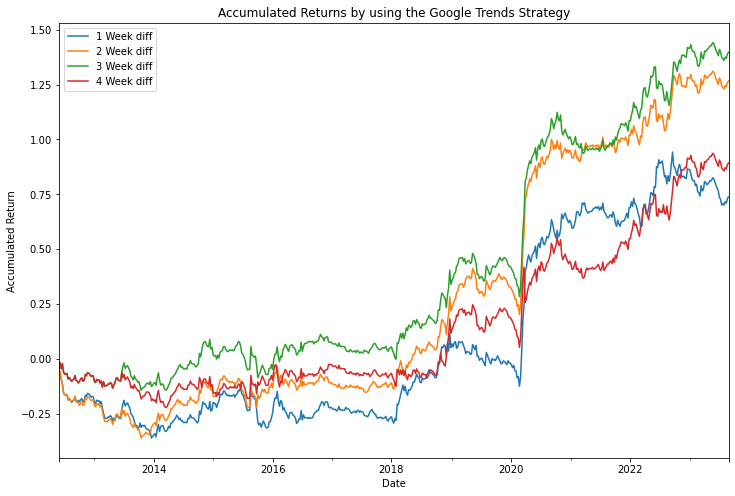

In [82]:
fig, ax = plt.subplots(1, figsize=(12,8))
(np.cumsum(SP_return_monday[263:] * Signal_SP_diff1.shift(1)[263:])).plot(ax = ax, legend=True, label='1 Week diff')
(np.cumsum(SP_return_monday[263:] * Signal_SP_diff2.shift(1)[263:])).plot(ax = ax, legend=True, label='2 Week diff')
(np.cumsum(SP_return_monday[263:] * Signal_SP_diff3.shift(1)[263:])).plot(ax = ax, legend=True, label='3 Week diff')
(np.cumsum(SP_return_monday[263:] * Signal_SP_diff4.shift(1)[263:])).plot(ax = ax, legend=True, label='4 Week diff')
ax.set_xlabel('Date')
ax.set_ylabel('Accumulated Return')
ax.set_title('Accumulated Returns by using the Google Trends Strategy')

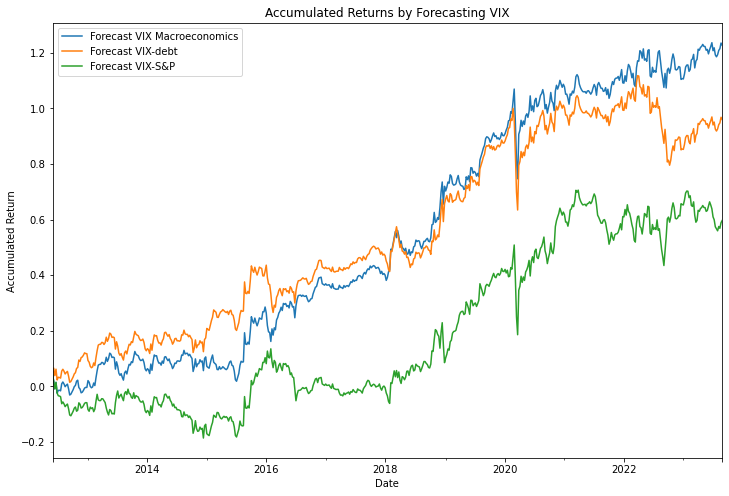

In [83]:
fig, ax = plt.subplots(1, figsize=(12,8))
(np.cumsum(SP_return_monday[263:] * VIX_predictions_signal['Predicted_VIX_Macroeconomics'])).plot(ax = ax, legend=True, 
                                                                                                  label='Forecast VIX Macroeconomics') 
(np.cumsum(SP_return_monday[263:] * VIX_predictions_signal['Predicted_VIX_Macro_trends_debt'])).plot(ax = ax, legend=True, 
                                                                                                     label='Forecast VIX-debt') 
(np.cumsum(SP_return_monday[263:] * VIX_predictions_signal['Predicted_VIX_Macro_trends_SP'])).plot(ax = ax, legend=True, 
                                                                                                   label='Forecast VIX-S&P') 

ax.set_xlabel('Date')
ax.set_ylabel('Accumulated Return')
ax.set_title('Accumulated Returns by Forecasting VIX')
plt.savefig('Accumulated_Returns_Forecast_VIX.png')

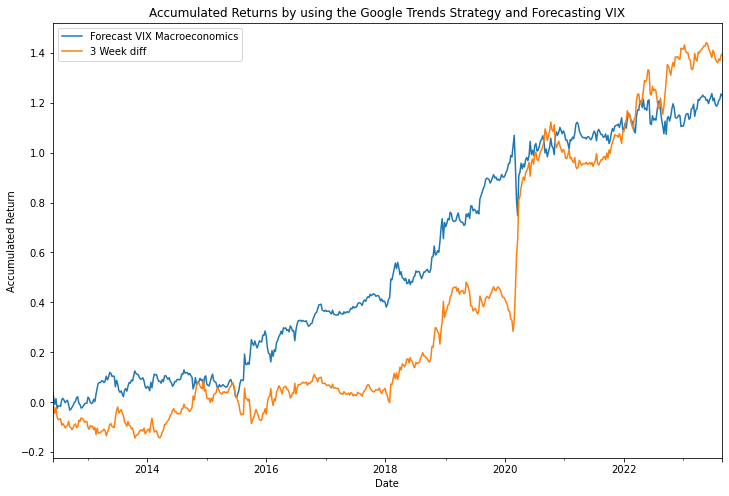

In [134]:
fig, ax = plt.subplots(1, figsize=(12,8))
(np.cumsum(SP_return_monday[263:] * VIX_predictions_signal['Predicted_VIX_Macroeconomics'])).plot(ax = ax, legend=True, 
                                                                                                  label='Forecast VIX Macroeconomics') 
(np.cumsum(SP_return_monday[263:] * Signal_SP_diff3.shift(1)[263:])).plot(ax = ax, legend=True, label='3 Week diff')

ax.set_xlabel('Date')
ax.set_ylabel('Accumulated Return')
ax.set_title('Accumulated Returns by using the Google Trends Strategy and Forecasting VIX')
plt.savefig('Comparison_Accumulated_Returns_Macro_Trends.png')

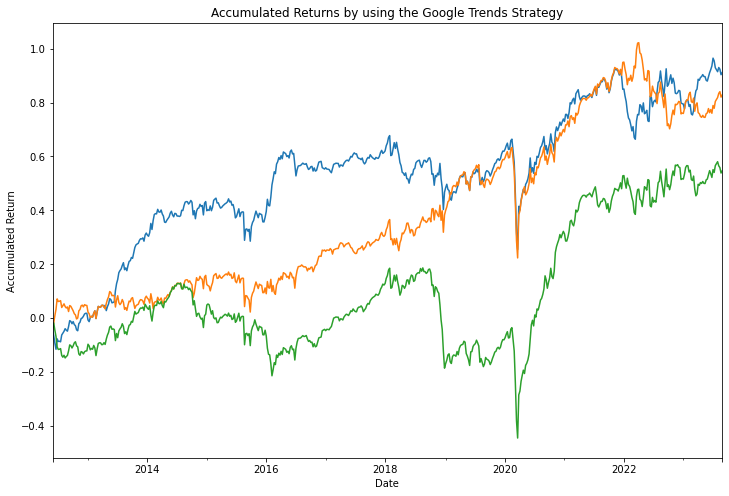

In [88]:
fig, ax = plt.subplots(1, figsize=(12,8))
(np.cumsum(SP_return_monday[263:] * SP_predictions_signal['Predicted_SP_Macroeconomics'])).plot(ax = ax) 
(np.cumsum(SP_return_monday[263:] * SP_predictions_signal['Predicted_SP_Trends_debt'])).plot(ax = ax) 
(np.cumsum(SP_return_monday[263:] * SP_predictions_signal['Predicted_SP_Trends_SP'])).plot(ax = ax) 

ax.set_xlabel('Date')
ax.set_ylabel('Accumulated Return')
ax.set_title('Accumulated Returns by using the Google Trends Strategy')
plt.savefig('Accumulated_Returns_Trends_SP.png')

# Analyzing changes on VIX and S&P 500

In [89]:
Positive_SP_weekly_return = (SP_return_monday > 0) + 0
Mean_pos_ret_SP = (Positive_SP_weekly_return * SP_return_monday).mean(skipna=True)
print(Mean_pos_ret_SP)
Mean_neg_ret_SP = ((1 - Positive_SP_weekly_return) * SP_return_monday).mean(skipna=True)
print(Mean_neg_ret_SP)

0.00983057734446492
-0.008573702749726724


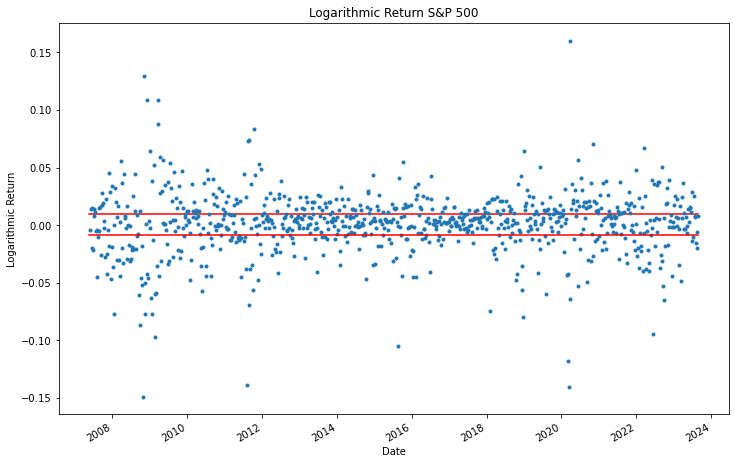

In [90]:
fig, ax = plt.subplots()
ax.plot([SP_return_monday.index[0], SP_return_monday.index[-1]], [Mean_pos_ret_SP, Mean_pos_ret_SP], color='r')
SP_return_monday.plot(style='.',figsize = (12,8), ax=ax)
ax.plot([SP_return_monday.index[0], SP_return_monday.index[-1]], [Mean_neg_ret_SP, Mean_neg_ret_SP], color='r')
ax.set_ylabel('Logarithmic Return')
ax.set_xlabel('Date')
ax.set_title('Logarithmic Return S&P 500')
plt.savefig('Logarithmic_return_SP.png')

In [92]:
Positive_VIX_weekly_diff = (Macroeconomics['VIX'] > 0) + 0
Mean_pos_diff_VIX = (Positive_VIX_weekly_diff * Macroeconomics['VIX']).mean(skipna=True)
print(Mean_pos_diff_VIX)
Mean_neg_diff_VIX = ((1 - Positive_VIX_weekly_diff) * Macroeconomics['VIX']).mean(skipna=True)
print(Mean_neg_diff_VIX)

0.923901060070672
-0.9203156654888103


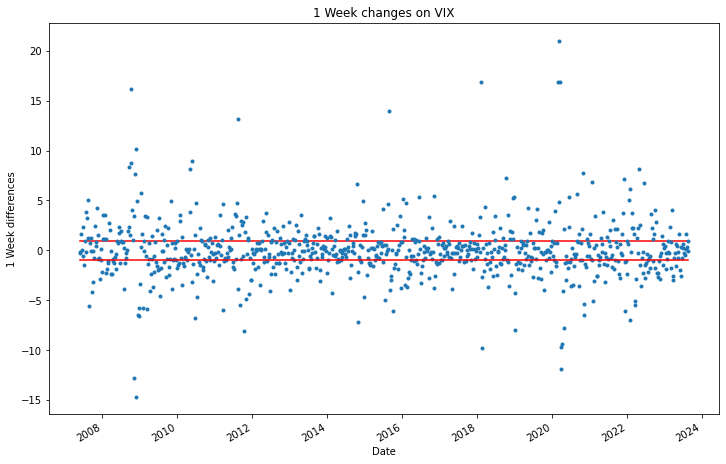

In [93]:
fig, ax = plt.subplots()
ax.plot([Macroeconomics['VIX'].index[0], Macroeconomics['VIX'].index[-1]], [Mean_pos_diff_VIX, Mean_pos_diff_VIX], color='r')
Macroeconomics['VIX'].plot(style='.',figsize = (12,8), ax=ax)
ax.plot([Macroeconomics['VIX'].index[0], Macroeconomics['VIX'].index[-1]], [Mean_neg_diff_VIX, Mean_neg_diff_VIX], color='r')
ax.set_ylabel('1 Week differences')
ax.set_xlabel('Date')
ax.set_title('1 Week changes on VIX')
plt.savefig('Weekly_differences_VIX.png')

# Focusing on big increments on VIX

In [124]:
VIX_return_increment.iloc[2:262]

2007-06-01    0
2007-06-08    1
2007-06-15    0
2007-06-22    0
2007-06-29    1
             ..
2012-04-20    0
2012-04-27    0
2012-05-04    1
2012-05-11    1
2012-05-18    1
Name: VIX, Length: 260, dtype: int32

In [125]:
VIX_big_increment = (Macroeconomics['VIX'] > Mean_pos_diff_VIX) + 0
VIX_big_increment.iloc[1:261]

2007-06-01    0
2007-06-08    1
2007-06-15    0
2007-06-22    0
2007-06-29    1
             ..
2012-04-20    0
2012-04-27    0
2012-05-04    0
2012-05-11    1
2012-05-18    1
Name: VIX, Length: 260, dtype: int32

In [126]:
Macroeconomics_predictions_big = []

for i in range(260, Macroeconomics.shape[0] - 2):
# Separating the independent and target variable on both data set
    x_train = Macroeconomics.iloc[i - 260: i, :]
    y_train = VIX_big_increment.iloc[i - 259: i + 1]
    x_test = Macroeconomics.iloc[i + 1]
    y_test = VIX_big_increment.iloc[i + 2]

    # Creating an object for model and fitting it on training data set
    LGBMC_model = LGBMClassifier(boosting_type='gbdt', num_leaves=2, max_depth=2, learning_rate=40, n_estimators=1020,
                             subsample_for_bin=485, objective='binary', min_split_gain=1e-19, min_child_weight=1e-19, 
                             subsample=0.01, colsample_bytree=0.37, reg_alpha=1e-19, reg_lambda=1e5,
                             importance_type='gain')
    LGBMC_model.fit(x_train, y_train)

    # Predicting the Target variable
    Macroeconomics_predictions_big.append(LGBMC_model.predict([x_test]))
    
Macroeconomics_predictions_VIX_big = pd.DataFrame(Macroeconomics_predictions_big, index=VIX_big_increment.index[262:], 
                                          columns=['Predicted_VIX+_Macroeconomics'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 82, number of negative: 178
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1876
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315385 -> initscore=-0.775064
[LightGBM] [Info] Start training from score -0.775064
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 82, number of negative: 178
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1872
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 79, number of negative: 181
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1865
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.303846 -> initscore=-0.829049
[LightGBM] [Info] Start training from score -0.829049
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 78, number of negative: 182
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1864
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.8

[LightGBM] [Info] Number of positive: 78, number of negative: 182
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1862
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.847298
[LightGBM] [Info] Start training from score -0.847298
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 78, number of negative: 182
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1865
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.8

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 76, number of negative: 184
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1862
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.292308 -> initscore=-0.884202
[LightGBM] [Info] Start training from score -0.884202
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 76, number of negative: 184
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1859
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.296154 -> initscore=-0.865681
[LightGBM] [Info] Start training from score -0.865681
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 77, number of negative: 183
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1856
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.296154 -> initscore=-0.865681
[LightGBM] [Info] Start training from score -0.865681
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 77, number of negative: 183
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_col_wise=true` to remove

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 72, number of negative: 188
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1841
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.276923 -> initscore=-0.959776
[LightGBM] [Info] Start training from score -0.959776
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 71, number of negative: 189
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1844
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 71, number of negative: 189
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1834
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.273077 -> initscore=-0.979067
[LightGBM] [Info] Start training from score -0.979067
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 71, number of negative: 189
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.273077 -> initscore=-0.9

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 71, number of negative: 189
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.273077 -> initscore=-0.979067
[LightGBM] [Info] Start training from score -0.979067
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 71, number of negative: 189
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 69, number of negative: 191
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1820
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265385 -> initscore=-1.018167
[LightGBM] [Info] Start training from score -1.018167
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 69, number of negative: 191
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265385 -> initscore=-1.0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 73, number of negative: 187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.280769 -> initscore=-0.940649
[LightGBM] [Info] Start training from score -0.940649
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 74, number of negative: 186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 74, number of negative: 186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1814
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.284615 -> initscore=-0.921682
[LightGBM] [Info] Start training from score -0.921682
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 74, number of negative: 186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1814
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.284615 -> initscore=-0.9

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 70, number of negative: 190
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1812
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.269231 -> initscore=-0.998529
[LightGBM] [Info] Start training from score -0.998529
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 69, number of negative: 191
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 69, number of negative: 191
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265385 -> initscore=-1.018167
[LightGBM] [Info] Start training from score -1.018167
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 69, number of negative: 191
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1804
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 72, number of negative: 188
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1811
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.276923 -> initscore=-0.959776
[LightGBM] [Info] Start training from score -0.959776
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 71, number of negative: 189
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.273077 -> initscore=-0.9

[LightGBM] [Info] Number of positive: 71, number of negative: 189
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1805
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.273077 -> initscore=-0.979067
[LightGBM] [Info] Start training from score -0.979067
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 72, number of negative: 188
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1805
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.276923 -> initscore=-0.9

[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.257692 -> initscore=-1.057998
[LightGBM] [Info] Start training from score -1.057998
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 66, number of negative: 194
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1805
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.253846 -> initscore=-1.078203
[LightGBM] [Info] Start training from score -1.078203
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 66, number of negative: 194
[LightGBM] [Warning] Auto-choosing col-wise multi-threading

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 66, number of negative: 194
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1811
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.253846 -> initscore=-1.078203
[LightGBM] [Info] Start training from score -1.078203
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 66, number of negative: 194
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 66, number of negative: 194
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.253846 -> initscore=-1.078203
[LightGBM] [Info] Start training from score -1.078203
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 66, number of negative: 194
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1816
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.253846 -> initscore=-1.0

[LightGBM] [Info] Number of positive: 62, number of negative: 198
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1816
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238462 -> initscore=-1.161133
[LightGBM] [Info] Start training from score -1.161133
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62, number of negative: 198
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238462 -> initscore=-1.1

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 61, number of negative: 199
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.234615 -> initscore=-1.182431
[LightGBM] [Info] Start training from score -1.182431
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 61, number of negative: 199
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1810
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 59, number of negative: 201
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226923 -> initscore=-1.225767
[LightGBM] [Info] Start training from score -1.225767
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 58, number of negative: 202
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 56, number of negative: 204
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215385 -> initscore=-1.292768
[LightGBM] [Info] Start training from score -1.292768
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 57, number of negative: 203
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219231 -> initscore=-1.2

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 56, number of negative: 204
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1812
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215385 -> initscore=-1.292768
[LightGBM] [Info] Start training from score -1.292768
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 56, number of negative: 204
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1813
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 59, number of negative: 201
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226923 -> initscore=-1.225767
[LightGBM] [Info] Start training from score -1.225767
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 58, number of negative: 202
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 58, number of negative: 202
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1819
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223077 -> initscore=-1.247825
[LightGBM] [Info] Start training from score -1.247825
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 58, number of negative: 202
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 59, number of negative: 201
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226923 -> initscore=-1.225767
[LightGBM] [Info] Start training from score -1.225767
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 59, number of negative: 201
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 56, number of negative: 204
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215385 -> initscore=-1.292768
[LightGBM] [Info] Start training from score -1.292768
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 56, number of negative: 204
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215385 -> initscore=-1.2

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 58, number of negative: 202
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1819
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223077 -> initscore=-1.247825
[LightGBM] [Info] Start training from score -1.247825
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 58, number of negative: 202
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1820
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 60, number of negative: 200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 60, number of negative: 200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading

[LightGBM] [Info] Number of positive: 59, number of negative: 201
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226923 -> initscore=-1.225767
[LightGBM] [Info] Start training from score -1.225767
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 60, number of negative: 200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.2

[LightGBM] [Info] Number of positive: 59, number of negative: 201
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1833
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226923 -> initscore=-1.225767
[LightGBM] [Info] Start training from score -1.225767
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 58, number of negative: 202
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223077 -> initscore=-1.2

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 58, number of negative: 202
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1832
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223077 -> initscore=-1.247825
[LightGBM] [Info] Start training from score -1.247825
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 58, number of negative: 202
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1835
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 59, number of negative: 201
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226923 -> initscore=-1.225767
[LightGBM] [Info] Start training from score -1.225767
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 59, number of negative: 201
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226923 -> initscore=-1.2

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 59, number of negative: 201
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226923 -> initscore=-1.225767
[LightGBM] [Info] Start training from score -1.225767
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 59, number of negative: 201
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 65, number of negative: 195
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1819
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 66, number of negative: 194
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.253846 -> initscore=-1.0

[LightGBM] [Info] Number of positive: 68, number of negative: 192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1819
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.261538 -> initscore=-1.037988
[LightGBM] [Info] Start training from score -1.037988
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 68, number of negative: 192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1820
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.261538 -> initscore=-1.0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 73, number of negative: 187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1811
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.280769 -> initscore=-0.940649
[LightGBM] [Info] Start training from score -0.940649
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 72, number of negative: 188
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1810
[LightGBM] [Info] Number of data points in the train set: 260, number of used feature

[LightGBM] [Info] Number of positive: 71, number of negative: 189
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.273077 -> initscore=-0.979067
[LightGBM] [Info] Start training from score -0.979067
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 72, number of negative: 188
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.276923 -> initscore=-0.9

[LightGBM] [Info] Number of positive: 72, number of negative: 188
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1807
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.276923 -> initscore=-0.959776
[LightGBM] [Info] Start training from score -0.959776
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 72, number of negative: 188
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.276923 -> initscore=-0.9

In [127]:
# Accuracy of predictions in all period
(VIX_return_increment.iloc[263:] == Macroeconomics_predictions_VIX_big['Predicted_VIX+_Macroeconomics']).sum() / Macroeconomics_predictions_VIX_big.shape[0]

0.5502555366269165

In [128]:
VIX_big_predictions_signal = -2 * Macroeconomics_predictions_VIX_big + 1
VIX_big_predictions_signal.index = SP_return_monday.index[263:]

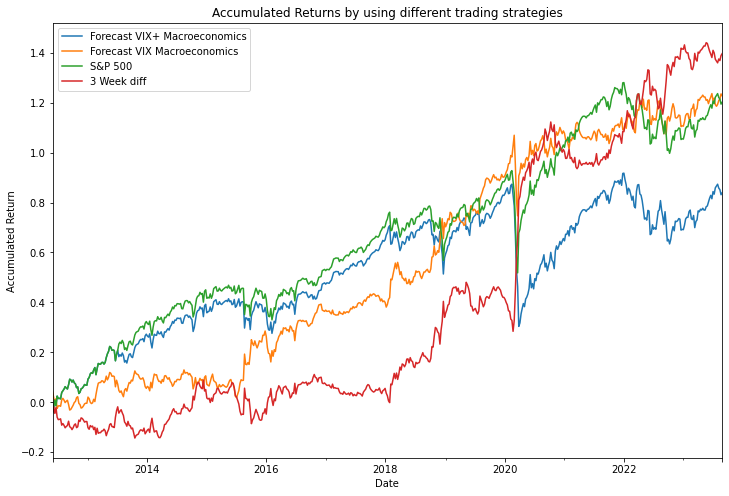

In [136]:
fig, ax = plt.subplots(1, figsize=(12,8))
(np.cumsum(SP_return_monday[263:] * VIX_big_predictions_signal['Predicted_VIX+_Macroeconomics'])).plot(ax = ax, legend=True, 
                                                                                                  label='Forecast VIX+ Macroeconomics') 
(np.cumsum(SP_return_monday[263:] * VIX_predictions_signal['Predicted_VIX_Macroeconomics'])).plot(ax = ax, legend=True, 
                                                                                                  label='Forecast VIX Macroeconomics') 
(np.cumsum(SP_return_monday[263:])).plot(ax = ax, legend=True, label='S&P 500') 
(np.cumsum(SP_return_monday[263:] * Signal_SP_diff3.shift(1)[263:])).plot(ax = ax, legend=True, label='3 Week diff')


ax.set_xlabel('Date')
ax.set_ylabel('Accumulated Return')
ax.set_title('Accumulated Returns by using different trading strategies')
plt.savefig('Final_comparison.png')